In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

c:\Users\tiago\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\tiago\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
import warnings

warnings.filterwarnings("ignore") 

In [3]:
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

In [4]:
TIME_COL = "Date"
TARGET = "Weekly_Sales"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"
FORECAST_HORIZON = 16 # weeks
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

In [5]:
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

In [6]:
# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

In [7]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
"medium")) # make size a categorical variable

In [8]:
store_selecionada = 2 
dept_selecionada= 1

# Filtrar o DataFrame para manter apenas os dados dessa loja
df = df[df['Store'] == store_selecionada]
df=df[df['Dept'] == dept_selecionada]


In [9]:
df

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
10244      2     1 2010-02-05      35034.06          0    A  medium   
10245      2     1 2010-02-12      60483.70          1    A  medium   
10246      2     1 2010-02-19      58221.52          0    A  medium   
10247      2     1 2010-02-26      25962.32          0    A  medium   
10248      2     1 2010-03-05      27372.05          0    A  medium   
...      ...   ...        ...           ...        ...  ...     ...   
10382      2     1 2012-09-28      27159.07          0    A  medium   
10383      2     1 2012-10-05      30789.27          0    A  medium   
10384      2     1 2012-10-12      34070.00          0    A  medium   
10385      2     1 2012-10-19      35897.95          0    A  medium   
10386      2     1 2012-10-26      41615.24          0    A  medium   

       Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
10244        40.19       2.572       0.00       0.00       0.00       0.00   
10245        38.49       2.548       0.00       0.00       0.00       0.00   
10246        39.69       2.514       0.00       0.00       0.00       0.00   
10247        46.10       2.561       0.00       0.00       0.00       0.00   
10248        47.17       2.625       0.00       0.00       0.00       0.00   
...            ...         ...        ...        ...        ...        ...   
10382        79.45       3.666    7106.05       1.91       1.65    1549.10   
10383        70.27       3.617    6037.76       0.00      10.04    3027.37   
10384        60.97       3.601    2145.50       0.00      33.31     586.83   
10385        68.08       3.594    4461.89       0.00       1.14    1579.67   
10386        69.79       3.506    6152.59     129.77     200.00     272.29   

       MarkDown5         CPI  Unemployment  
10244       0.00  210.752605         8.324  
10245       0.00  210.897994         8.324  
10246       0.00  210.945160         8.324  
10247       0.00  210.975957         8.324  
10248       0.00  211.006754         8.324  
...          ...         ...           ...  
10382    3946.03  222.616433         6.565  
10383    3853.40  222.815930         6.170  
10384   10421.01  223.015426         6.170  
10385    2642.29  223.059808         6.170  
10386    2924.15  223.078337         6.170  

[143 rows x 16 columns]

In [10]:
# 16 weeks to for test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

In [11]:
train

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
10244      2     1 2010-02-05      35034.06          0    A  medium   
10245      2     1 2010-02-12      60483.70          1    A  medium   
10246      2     1 2010-02-19      58221.52          0    A  medium   
10247      2     1 2010-02-26      25962.32          0    A  medium   
10248      2     1 2010-03-05      27372.05          0    A  medium   
...      ...   ...        ...           ...        ...  ...     ...   
10366      2     1 2012-06-08      24826.25          0    A  medium   
10367      2     1 2012-06-15      24016.43          0    A  medium   
10368      2     1 2012-06-22      24155.67          0    A  medium   
10369      2     1 2012-06-29      23580.74          0    A  medium   
10370      2     1 2012-07-06      24052.70          0    A  medium   

       Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
10244        40.19       2.572       0.00       0.00       0.00       0.00   
10245        38.49       2.548       0.00       0.00       0.00       0.00   
10246        39.69       2.514       0.00       0.00       0.00       0.00   
10247        46.10       2.561       0.00       0.00       0.00       0.00   
10248        47.17       2.625       0.00       0.00       0.00       0.00   
...            ...         ...        ...        ...        ...        ...   
10366        78.69       3.452   12162.04     463.60      78.39    3610.78   
10367        80.56       3.393    8573.41     195.00       0.19    4455.38   
10368        81.04       3.346   12126.02     314.00      60.99    6058.60   
10369        86.32       3.286    8495.34     275.80       0.00    1935.16   
10370        84.20       3.227   12355.50     295.05     100.15    6720.40   

       MarkDown5         CPI  Unemployment  
10244       0.00  210.752605         8.324  
10245       0.00  210.897994         8.324  
10246       0.00  210.945160         8.324  
10247       0.00  210.975957         8.324  
10248       0.00  211.006754         8.324  
...          ...         ...           ...  
10366   10877.64  221.387747         6.891  
10367    5288.61  221.400990         6.891  
10368   36430.33  221.441162         6.891  
10369    5686.13  221.481334         6.891  
10370    5506.53  221.521506         6.565  

[127 rows x 16 columns]

In [12]:
test

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
10371      2     1 2012-07-13      23148.57          0    A  medium   
10372      2     1 2012-07-20      23813.13          0    A  medium   
10373      2     1 2012-07-27      23025.51          0    A  medium   
10374      2     1 2012-08-03      22851.99          0    A  medium   
10375      2     1 2012-08-10      23261.95          0    A  medium   
10376      2     1 2012-08-17      24793.54          0    A  medium   
10377      2     1 2012-08-24      22839.77          0    A  medium   
10378      2     1 2012-08-31      25343.45          0    A  medium   
10379      2     1 2012-09-07      25270.06          1    A  medium   
10380      2     1 2012-09-14      26435.20          0    A  medium   
10381      2     1 2012-09-21      26303.04          0    A  medium   
10382      2     1 2012-09-28      27159.07          0    A  medium   
10383      2     1 2012-10-05      30789.27          0    A  medium   
10384      2     1 2012-10-12      34070.00          0    A  medium   
10385      2     1 2012-10-19      35897.95          0    A  medium   
10386      2     1 2012-10-26      41615.24          0    A  medium   

       Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
10371        80.17       3.256    8354.65     342.25      20.53    5674.44   
10372        83.23       3.311    6961.58     241.20      24.97    3401.36   
10373        86.37       3.407    6999.14     197.72       2.53    6319.33   
10374        90.22       3.417   27650.68     164.58      43.02   21801.90   
10375        88.55       3.494    5554.54     142.30      13.43    4187.43   
10376        84.79       3.571    4774.16     330.78      10.53    4253.28   
10377        76.91       3.620    4759.70     211.38       6.62    2972.88   
10378        82.64       3.638   17500.26      73.22      21.38   12878.62   
10379        87.65       3.730   10658.86     149.28      60.97    2920.90   
10380        75.88       3.717    8325.93       0.00      37.32    1808.69   
10381        71.09       3.721    6707.94       3.82      15.55    1001.42   
10382        79.45       3.666    7106.05       1.91       1.65    1549.10   
10383        70.27       3.617    6037.76       0.00      10.04    3027.37   
10384        60.97       3.601    2145.50       0.00      33.31     586.83   
10385        68.08       3.594    4461.89       0.00       1.14    1579.67   
10386        69.79       3.506    6152.59     129.77     200.00     272.29   

       MarkDown5         CPI  Unemployment  
10371    5012.22  221.561678         6.565  
10372    2453.42  221.570112         6.565  
10373    5007.01  221.578546         6.565  
10374    6652.98  221.586980         6.565  
10375    5286.19  221.595414         6.565  
10376    4927.26  221.675146         6.565  
10377    5102.26  221.808352         6.565  
10378    4756.50  221.941558         6.565  
10379    3275.57  222.074763         6.565  
10380    9314.55  222.217440         6.565  
10381    7607.94  222.416936         6.565  
10382    3946.03  222.616433         6.565  
10383    3853.40  222.815930         6.170  
10384   10421.01  223.015426         6.170  
10385    2642.29  223.059808         6.170  
10386    2924.15  223.078337         6.170

In [13]:
# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(
df=train,
group_cols=STATIC_COV,
time_col=TIME_COL,
value_cols=TARGET,
freq=FREQ, 
fill_missing_dates=True,
fillna_value=0)

In [14]:
# create dynamic covariates for each serie in the training darts
dynamic_covariates = []
for serie in train_darts:
    # add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        serie,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )
    covariate = covariate.stack(
        datetime_attribute_timeseries(
            serie,
            attribute="week",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        )
    )


    dynamic_covariates.append(covariate)


In [15]:
# scale covariates
dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

In [16]:
TFT_params = {
    "input_chunk_length": 52, # number of weeks to lookback
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 2,
    "lstm_layers": 4,
    "num_attention_heads": 1,
    "dropout": 0.1,
    "batch_size":16,
    "n_epochs": 15,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": False,
    "optimizer_kwargs": {"lr": 1e-3},}

tft_model = TFTModel(**TFT_params)
tft_model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
pred = PIPELINE.inverse_transform(tft_model.predict(n=FORECAST_HORIZON, series=data_transformed, num_samples=50, future_covariates=dynamic_covariates_transformed))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

TFT_params = {
    "input_chunk_length": 52, # number of weeks to lookback
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 2,
    "lstm_layers": 4,
    "num_attention_heads": 1,
    "dropout": 0.2,
    "batch_size":32,
    "n_epochs": 10,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": False,
    "optimizer_kwargs": {"lr": 1e-3},}

count    44.000000
mean      0.320553
std       0.186566
min       0.019553
25%       0.189913
50%       0.281626
75%       0.451879
max       0.803905
Name: mape, dtype: float64




In [17]:
# Calcule os resíduos
residual_values = tft_model.residuals(data_transformed, future_covariates=dynamic_covariates_transformed, forecast_horizon=FORECAST_HORIZON)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 5.7 K 
6  | static_context_grn

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
residual_values

[<TimeSeries (DataArray) (time: 44, component: 1, sample: 1)>
 array([[[-0.46191189]],
 
        [[-0.43954421]],
 
        [[-0.42340065]],
 
        [[-0.38070635]],
 
        [[-0.3242322 ]],
 
        [[-0.30505241]],
 
        [[-0.24308534]],
 
        [[-0.08154468]],
 
        [[ 0.1106481 ]],
 
        [[-0.18300304]],
 
 ...
 
        [[-0.31359018]],
 
        [[-0.27588087]],
 
        [[-0.27112545]],
 
        [[-0.30838543]],
 
        [[-0.31947852]],
 
        [[-0.12452197]],
 
        [[-0.30897484]],
 
        [[-0.30794269]],
 
        [[-0.3256925 ]],
 
        [[-0.17455321]]])
 Coordinates:
   * time       (time) datetime64[ns] 2011-09-09 2011-09-16 ... 2012-07-06
   * component  (component) object 'Weekly_Sales'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  static_covariates  Store  Dept  Type  Size\ncomponent...
     hierarchy:          None]

In [19]:
pred

[<TimeSeries (DataArray) (Date: 16, component: 1, sample: 50)>
 array([[[29437.67350066, 29437.67350066, 37100.46624265,  2139.62697247,
           2139.62697247, 33190.12691172, 29437.67350066,  2139.62697247,
          31056.20002584, 52728.03507915, 36747.02826303, 37601.05869993,
          29437.67350066, 45974.40011087, 11627.09504422, 29437.67350066,
          56668.99719593,  2139.62697247,  2139.62697247,  2139.62697247,
          54598.17822095, 29437.67350066,  2139.62697247,  2139.62697247,
          55034.12876232,  2139.62697247, 29437.67350066, 62598.13090022,
          43446.70704303,  2139.62697247,  2139.62697247,  2139.62697247,
          32888.98318026, 69896.91315134, 29437.67350066, 29437.67350066,
          38897.25552313, 29437.67350066, 39726.97009196,  2139.62697247,
           2139.62697247, 29437.67350066,  2139.62697247, 63390.770797  ,
           2139.62697247, 29437.67350066, 29437.67350066, 29437.67350066,
          44848.48505554, 29437.67350066]],
 
   

In [20]:
df_pred = pd.DataFrame(pred[0].values(), index=pred[0].time_index, columns=['forecast'])
df_pred.reset_index(inplace=True)
df_pred

Date      forecast
0  2012-07-13  29437.673501
1  2012-07-20   2139.626991
2  2012-07-27   2139.627044
3  2012-08-03  75409.481239
4  2012-08-10  29437.673496
5  2012-08-17   2139.626843
6  2012-08-24  52619.025164
7  2012-08-31   2139.626937
8  2012-09-07  60794.685101
9  2012-09-14   5718.153797
10 2012-09-21   2139.626951
11 2012-09-28  29437.673494
12 2012-10-05  37800.985814
13 2012-10-12  49549.690963
14 2012-10-19   2575.095441
15 2012-10-26  42936.459121

In [21]:
forecast = df_pred['forecast']
forecast

0     29437.673501
1      2139.626991
2      2139.627044
3     75409.481239
4     29437.673496
5      2139.626843
6     52619.025164
7      2139.626937
8     60794.685101
9      5718.153797
10     2139.626951
11    29437.673494
12    37800.985814
13    49549.690963
14     2575.095441
15    42936.459121
Name: forecast, dtype: float64

In [22]:
test.reset_index(drop=True, inplace=True)

df_pred['Residuals']= test['Weekly_Sales'] - df_pred['forecast']
df_pred

Date      forecast     Residuals
0  2012-07-13  29437.673501  -6289.103501
1  2012-07-20   2139.626991  21673.503009
2  2012-07-27   2139.627044  20885.882956
3  2012-08-03  75409.481239 -52557.491239
4  2012-08-10  29437.673496  -6175.723496
5  2012-08-17   2139.626843  22653.913157
6  2012-08-24  52619.025164 -29779.255164
7  2012-08-31   2139.626937  23203.823063
8  2012-09-07  60794.685101 -35524.625101
9  2012-09-14   5718.153797  20717.046203
10 2012-09-21   2139.626951  24163.413049
11 2012-09-28  29437.673494  -2278.603494
12 2012-10-05  37800.985814  -7011.715814
13 2012-10-12  49549.690963 -15479.690963
14 2012-10-19   2575.095441  33322.854559
15 2012-10-26  42936.459121  -1321.219121

In [23]:
residual_values=PIPELINE.inverse_transform(residual_values)

In [24]:
df = pd.DataFrame(residual_values[0].values(), index=residual_values[0].time_index, columns=['Residuals'])
df.reset_index(inplace=True)

In [25]:
df = df.rename(columns={'time': 'Date'})


In [26]:
df_pred = df_pred.drop('forecast', axis=1)
df_concatenado = pd.concat([df, df_pred], ignore_index=True)
df_concatenado


Date     Residuals
0  2011-09-09 -10318.435885
1  2011-09-16  -8894.215375
2  2011-09-23  -7866.304734
3  2011-09-30  -5147.824642
4  2011-10-07  -1551.938747
5  2011-10-14   -330.702007
6  2011-10-21   3614.935644
7  2011-10-28  13900.735166
8  2011-11-04  26138.250869
9  2011-11-11   7440.563828
10 2011-11-18   8145.375574
11 2011-11-25  -4047.472803
12 2011-12-02    323.322298
13 2011-12-09  14159.990995
14 2011-12-16  33626.458815
15 2011-12-23  46179.619680
16 2011-12-30   4949.431869
17 2012-01-06  -9461.056416
18 2012-01-13  -4798.583124
19 2012-01-20  -2776.737954
20 2012-01-27  -3228.306892
21 2012-02-03   2863.106123
22 2012-02-10  15209.800604
23 2012-02-17  62885.274185
24 2012-02-24   -469.258988
25 2012-03-02   -405.311091
26 2012-03-09    142.452556
27 2012-03-16   1299.559411
28 2012-03-23  15486.900523
29 2012-03-30  10868.851525
30 2012-04-06  49732.361470
31 2012-04-13  39467.458493
32 2012-04-20   9756.651178
33 2012-04-27  -1328.486174
34 2012-05-04   -874.328465
35 2012-05-11   1526.741614
36 2012-05-18   1829.533768
37 2012-05-25   -542.925617
38 2012-06-01  -1249.257605
39 2012-06-08  11164.236369
40 2012-06-15   -580.455382
41 2012-06-22   -514.734680
42 2012-06-29  -1644.920596
43 2012-07-06   7978.590902
44 2012-07-13  -6289.103501
45 2012-07-20  21673.503009
46 2012-07-27  20885.882956
47 2012-08-03 -52557.491239
48 2012-08-10  -6175.723496
49 2012-08-17  22653.913157
50 2012-08-24 -29779.255164
51 2012-08-31  23203.823063
52 2012-09-07 -35524.625101
53 2012-09-14  20717.046203
54 2012-09-21  24163.413049
55 2012-09-28  -2278.603494
56 2012-10-05  -7011.715814
57 2012-10-12 -15479.690963
58 2012-10-19  33322.854559
59 2012-10-26  -1321.219121

In [27]:
train_with_residuals = pd.merge(train, df_concatenado, on='Date', how='inner')
test_with_residuals = pd.merge(test, df_concatenado, on='Date', how='inner')

In [28]:
test_with_residuals

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0       2     1 2012-07-13      23148.57          0    A  medium        80.17   
1       2     1 2012-07-20      23813.13          0    A  medium        83.23   
2       2     1 2012-07-27      23025.51          0    A  medium        86.37   
3       2     1 2012-08-03      22851.99          0    A  medium        90.22   
4       2     1 2012-08-10      23261.95          0    A  medium        88.55   
5       2     1 2012-08-17      24793.54          0    A  medium        84.79   
6       2     1 2012-08-24      22839.77          0    A  medium        76.91   
7       2     1 2012-08-31      25343.45          0    A  medium        82.64   
8       2     1 2012-09-07      25270.06          1    A  medium        87.65   
9       2     1 2012-09-14      26435.20          0    A  medium        75.88   
10      2     1 2012-09-21      26303.04          0    A  medium        71.09   
11      2     1 2012-09-28      27159.07          0    A  medium        79.45   
12      2     1 2012-10-05      30789.27          0    A  medium        70.27   
13      2     1 2012-10-12      34070.00          0    A  medium        60.97   
14      2     1 2012-10-19      35897.95          0    A  medium        68.08   
15      2     1 2012-10-26      41615.24          0    A  medium        69.79   

    Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0        3.256    8354.65     342.25      20.53    5674.44    5012.22   
1        3.311    6961.58     241.20      24.97    3401.36    2453.42   
2        3.407    6999.14     197.72       2.53    6319.33    5007.01   
3        3.417   27650.68     164.58      43.02   21801.90    6652.98   
4        3.494    5554.54     142.30      13.43    4187.43    5286.19   
5        3.571    4774.16     330.78      10.53    4253.28    4927.26   
6        3.620    4759.70     211.38       6.62    2972.88    5102.26   
7        3.638   17500.26      73.22      21.38   12878.62    4756.50   
8        3.730   10658.86     149.28      60.97    2920.90    3275.57   
9        3.717    8325.93       0.00      37.32    1808.69    9314.55   
10       3.721    6707.94       3.82      15.55    1001.42    7607.94   
11       3.666    7106.05       1.91       1.65    1549.10    3946.03   
12       3.617    6037.76       0.00      10.04    3027.37    3853.40   
13       3.601    2145.50       0.00      33.31     586.83   10421.01   
14       3.594    4461.89       0.00       1.14    1579.67    2642.29   
15       3.506    6152.59     129.77     200.00     272.29    2924.15   

           CPI  Unemployment     Residuals  
0   221.561678         6.565  -6289.103501  
1   221.570112         6.565  21673.503009  
2   221.578546         6.565  20885.882956  
3   221.586980         6.565 -52557.491239  
4   221.595414         6.565  -6175.723496  
5   221.675146         6.565  22653.913157  
6   221.808352         6.565 -29779.255164  
7   221.941558         6.565  23203.823063  
8   222.074763         6.565 -35524.625101  
9   222.217440         6.565  20717.046203  
10  222.416936         6.565  24163.413049  
11  222.616433         6.565  -2278.603494  
12  222.815930         6.170  -7011.715814  
13  223.015426         6.170 -15479.690963  
14  223.059808         6.170  33322.854559  
15  223.078337         6.170  -1321.219121

In [29]:
train_with_residuals

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0       2     1 2011-09-09      22549.64          1    A  medium        77.97   
1       2     1 2011-09-16      23973.86          0    A  medium        78.85   
2       2     1 2011-09-23      24204.22          0    A  medium        75.58   
3       2     1 2011-09-30      24949.42          0    A  medium        78.14   
4       2     1 2011-10-07      28071.56          0    A  medium        69.92   
5       2     1 2011-10-14      29264.62          0    A  medium        71.67   
6       2     1 2011-10-21      33205.32          0    A  medium        64.53   
7       2     1 2011-10-28      43490.95          0    A  medium        65.87   
8       2     1 2011-11-04      55729.13          0    A  medium        55.53   
9       2     1 2011-11-11      23151.55          0    A  medium        59.33   
10      2     1 2011-11-18      23923.11          0    A  medium        62.01   
11      2     1 2011-11-25      25542.74          1    A  medium        56.36   
12      2     1 2011-12-02      29959.08          0    A  medium        48.74   
13      2     1 2011-12-09      43639.97          0    A  medium        41.76   
14      2     1 2011-12-16      63109.72          0    A  medium        50.13   
15      2     1 2011-12-23      75779.45          0    A  medium        46.66   
16      2     1 2011-12-30      31246.27          1    A  medium        44.57   
17      2     1 2012-01-06      20481.45          0    A  medium        46.75   
18      2     1 2012-01-13      21569.90          0    A  medium        45.99   
19      2     1 2012-01-20      23397.02          0    A  medium        51.70   
20      2     1 2012-01-27      22833.08          0    A  medium        50.50   
21      2     1 2012-02-03      28813.06          0    A  medium        55.21   
22      2     1 2012-02-10      41247.02          1    A  medium        46.98   
23      2     1 2012-02-17      77394.09          0    A  medium        43.82   
24      2     1 2012-02-24      25613.67          0    A  medium        54.63   
25      2     1 2012-03-02      25556.15          0    A  medium        58.79   
26      2     1 2012-03-09      26173.93          0    A  medium        57.11   
27      2     1 2012-03-16      27320.08          0    A  medium        63.68   
28      2     1 2012-03-23      29868.82          0    A  medium        64.01   
29      2     1 2012-03-30      37052.68          0    A  medium        66.83   
30      2     1 2012-04-06      75970.97          0    A  medium        68.43   
31      2     1 2012-04-13      56093.13          0    A  medium        68.08   
32      2     1 2012-04-20      22568.57          0    A  medium        65.69   
33      2     1 2012-04-27      22414.38          0    A  medium        67.20   
34      2     1 2012-05-04      22711.04          0    A  medium        76.73   
35      2     1 2012-05-11      25661.21          0    A  medium        73.87   
36      2     1 2012-05-18      25982.70          0    A  medium        71.27   
37      2     1 2012-05-25      23561.25          0    A  medium        78.19   
38      2     1 2012-06-01      23076.47          0    A  medium        78.38   
39      2     1 2012-06-08      24826.25          0    A  medium        78.69   
40      2     1 2012-06-15      24016.43          0    A  medium        80.56   
41      2     1 2012-06-22      24155.67          0    A  medium        81.04   
42      2     1 2012-06-29      23580.74          0    A  medium        86.32   
43      2     1 2012-07-06      24052.70          0    A  medium        84.20   

    Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0        3.546       0.00       0.00       0.00       0.00       0.00   
1        3.526       0.00       0.00       0.00       0.00       0.00   
2        3.467       0.00       0.00       0.00       0.00       0.00   
3        3.355       0.00       0.00       0.00       0.00       0

In [30]:
train_with_residuals["mape"]= abs(train_with_residuals["Residuals"])/train_with_residuals["Weekly_Sales"]

In [31]:
train_with_residuals["mape"].describe()

count    44.000000
mean      0.247645
std       0.219429
min       0.005443
25%       0.054998
50%       0.182395
75%       0.386325
max       0.812533
Name: mape, dtype: float64

In [32]:
train_with_residuals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         44 non-null     int64         
 1   Dept          44 non-null     int64         
 2   Date          44 non-null     datetime64[ns]
 3   Weekly_Sales  44 non-null     float64       
 4   IsHoliday     44 non-null     int32         
 5   Type          44 non-null     object        
 6   Size          44 non-null     object        
 7   Temperature   44 non-null     float64       
 8   Fuel_Price    44 non-null     float64       
 9   MarkDown1     44 non-null     float64       
 10  MarkDown2     44 non-null     float64       
 11  MarkDown3     44 non-null     float64       
 12  MarkDown4     44 non-null     float64       
 13  MarkDown5     44 non-null     float64       
 14  CPI           44 non-null     float64       
 15  Unemployment  44 non-null     float64     

In [33]:
X_train= train_with_residuals
y_train= X_train['Residuals']
X_train=X_train.drop(columns=['Residuals'])
X_test = test_with_residuals
y_test = X_test['Residuals']
X_test=X_test.drop(columns=['Residuals'])



In [34]:

X_test

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0       2     1 2012-07-13      23148.57          0    A  medium        80.17   
1       2     1 2012-07-20      23813.13          0    A  medium        83.23   
2       2     1 2012-07-27      23025.51          0    A  medium        86.37   
3       2     1 2012-08-03      22851.99          0    A  medium        90.22   
4       2     1 2012-08-10      23261.95          0    A  medium        88.55   
5       2     1 2012-08-17      24793.54          0    A  medium        84.79   
6       2     1 2012-08-24      22839.77          0    A  medium        76.91   
7       2     1 2012-08-31      25343.45          0    A  medium        82.64   
8       2     1 2012-09-07      25270.06          1    A  medium        87.65   
9       2     1 2012-09-14      26435.20          0    A  medium        75.88   
10      2     1 2012-09-21      26303.04          0    A  medium        71.09   
11      2     1 2012-09-28      27159.07          0    A  medium        79.45   
12      2     1 2012-10-05      30789.27          0    A  medium        70.27   
13      2     1 2012-10-12      34070.00          0    A  medium        60.97   
14      2     1 2012-10-19      35897.95          0    A  medium        68.08   
15      2     1 2012-10-26      41615.24          0    A  medium        69.79   

    Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0        3.256    8354.65     342.25      20.53    5674.44    5012.22   
1        3.311    6961.58     241.20      24.97    3401.36    2453.42   
2        3.407    6999.14     197.72       2.53    6319.33    5007.01   
3        3.417   27650.68     164.58      43.02   21801.90    6652.98   
4        3.494    5554.54     142.30      13.43    4187.43    5286.19   
5        3.571    4774.16     330.78      10.53    4253.28    4927.26   
6        3.620    4759.70     211.38       6.62    2972.88    5102.26   
7        3.638   17500.26      73.22      21.38   12878.62    4756.50   
8        3.730   10658.86     149.28      60.97    2920.90    3275.57   
9        3.717    8325.93       0.00      37.32    1808.69    9314.55   
10       3.721    6707.94       3.82      15.55    1001.42    7607.94   
11       3.666    7106.05       1.91       1.65    1549.10    3946.03   
12       3.617    6037.76       0.00      10.04    3027.37    3853.40   
13       3.601    2145.50       0.00      33.31     586.83   10421.01   
14       3.594    4461.89       0.00       1.14    1579.67    2642.29   
15       3.506    6152.59     129.77     200.00     272.29    2924.15   

           CPI  Unemployment  
0   221.561678         6.565  
1   221.570112         6.565  
2   221.578546         6.565  
3   221.586980         6.565  
4   221.595414         6.565  
5   221.675146         6.565  
6   221.808352         6.565  
7   221.941558         6.565  
8   222.074763         6.565  
9   222.217440         6.565  
10  222.416936         6.565  
11  222.616433         6.565  
12  222.815930         6.170  
13  223.015426         6.170  
14  223.059808         6.170  
15  223.078337         6.170

In [37]:
X_test=X_test[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',"IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]

In [38]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

model = CatBoostRegressor()

param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.001],
    'depth': [4, 6, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=10)

grid_search.fit(X_train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',"IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']], y_train)

print("Melhores parâmetros:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START depth=4, iterations=100, learning_rate=0.01................
0:	learn: 17550.7908298	total: 406us	remaining: 40.2ms
1:	learn: 17502.6500126	total: 687us	remaining: 33.7ms
2:	learn: 17469.0609077	total: 984us	remaining: 31.8ms
3:	learn: 17432.1865640	total: 1.25ms	remaining: 30ms
4:	learn: 17402.3380637	total: 1.51ms	remaining: 28.8ms
5:	learn: 17369.2224801	total: 1.76ms	remaining: 27.6ms
6:	learn: 17334.1671683	total: 2ms	remaining: 26.6ms
7:	learn: 17277.9621478	total: 2.23ms	remaining: 25.7ms
8:	learn: 17234.5221437	total: 2.46ms	remaining: 24.9ms
9:	learn: 17205.3782354	total: 2.69ms	remaining: 24.2ms
10:	learn: 17185.0999342	total: 2.9ms	remaining: 23.5ms
11:	learn: 17160.7531332	total: 3.14ms	remaining: 23ms
12:	learn: 17143.8061444	total: 3.37ms	remaining: 22.6ms
13:	learn: 17112.6588689	total: 3.58ms	remaining: 22ms
14:	learn: 17081.3514323	total: 3.83ms	remaining: 21.7ms
15:	learn: 17039.4782602	t

In [39]:
from sklearn.metrics import mean_squared_error
best_model = grid_search.best_estimator_
y_pred_catboost = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_catboost, squared=False)
print("RMSE on residuals test set:", rmse)

RMSE on residuals test set: 24668.08965022753


In [40]:
forecast_final_catboost= forecast+y_pred_catboost


In [41]:
print("RMSE on final forecast test set:", mean_squared_error(test['Weekly_Sales'], forecast_final_catboost, squared=False))

RMSE on final forecast test set: 24668.08965022753


In [42]:
X_test=X_test[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',"IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]

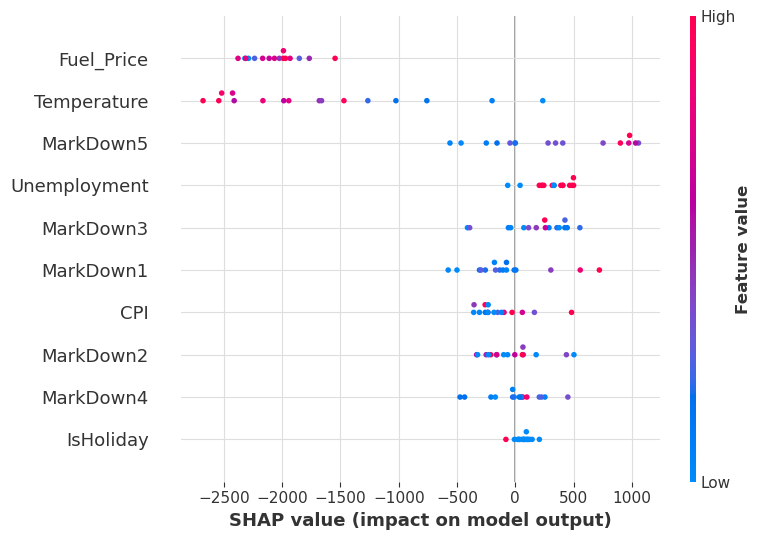

In [43]:
import pandas as pd
from catboost import CatBoostRegressor
import shap


explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


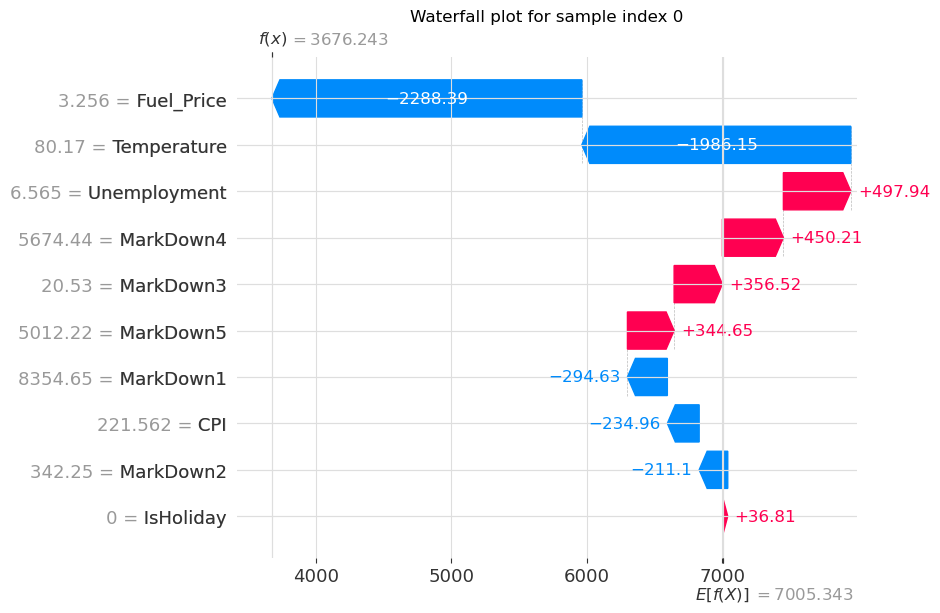

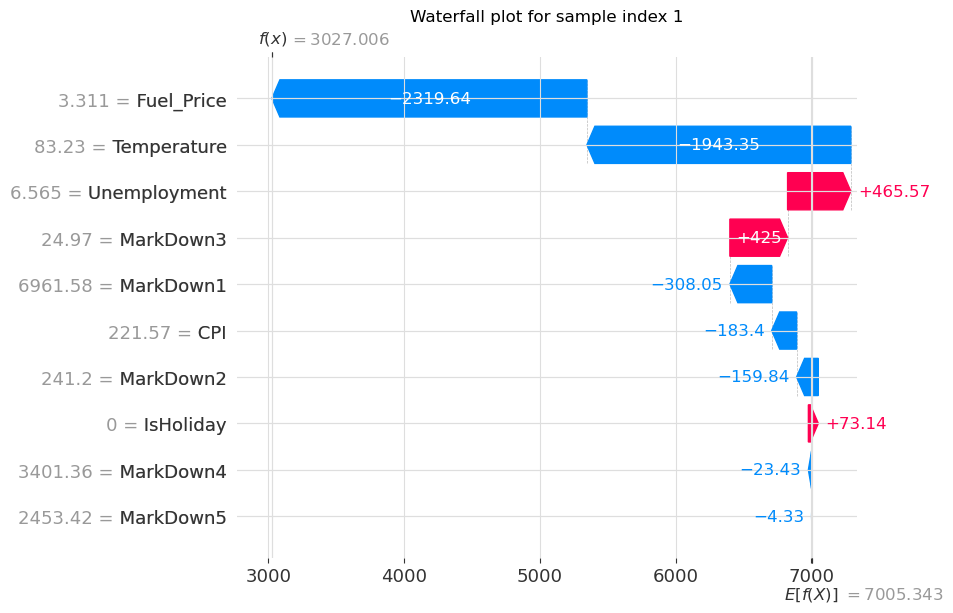

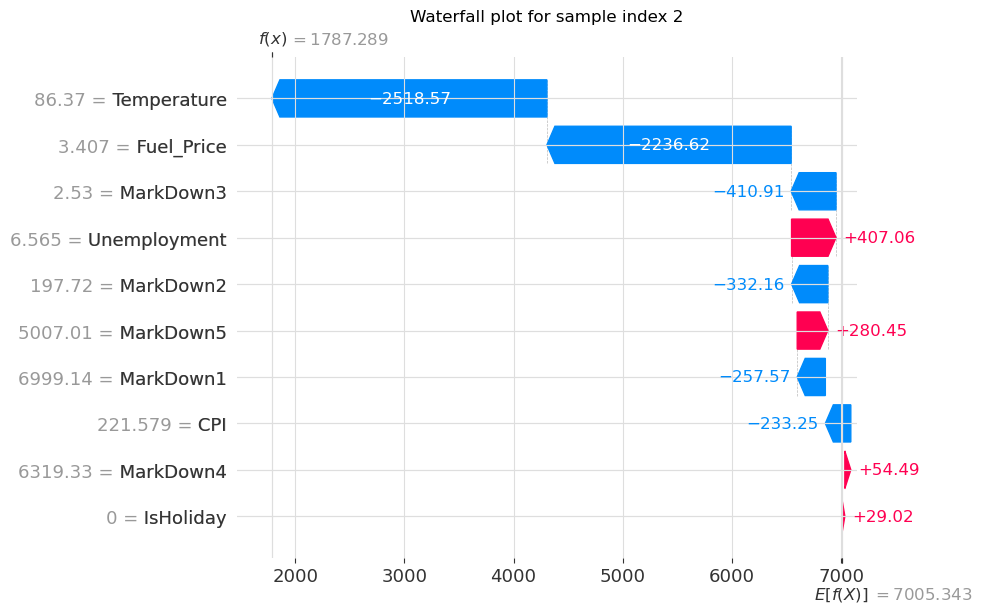

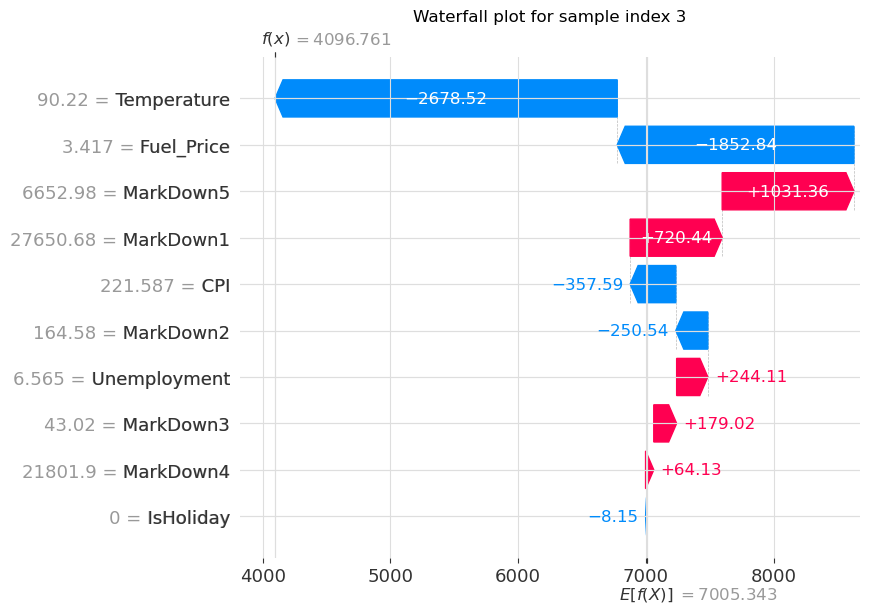

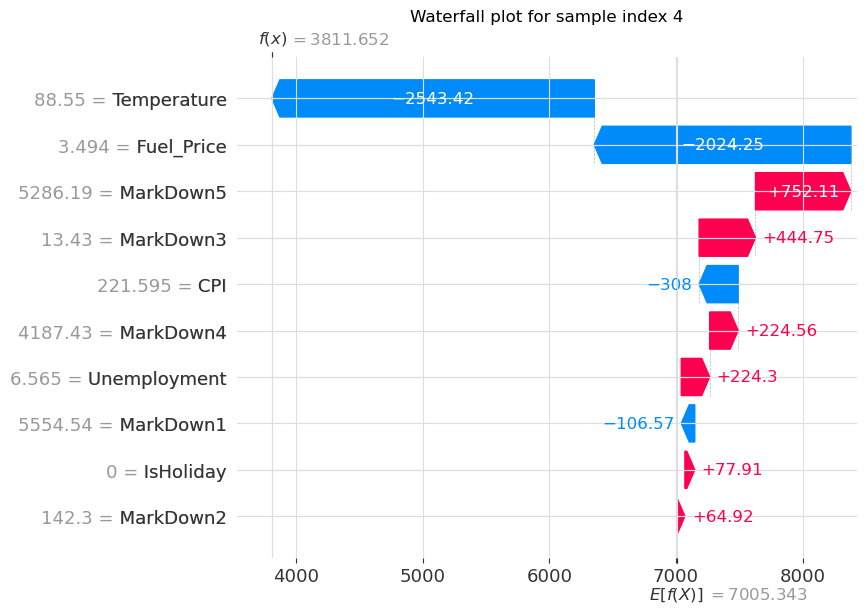

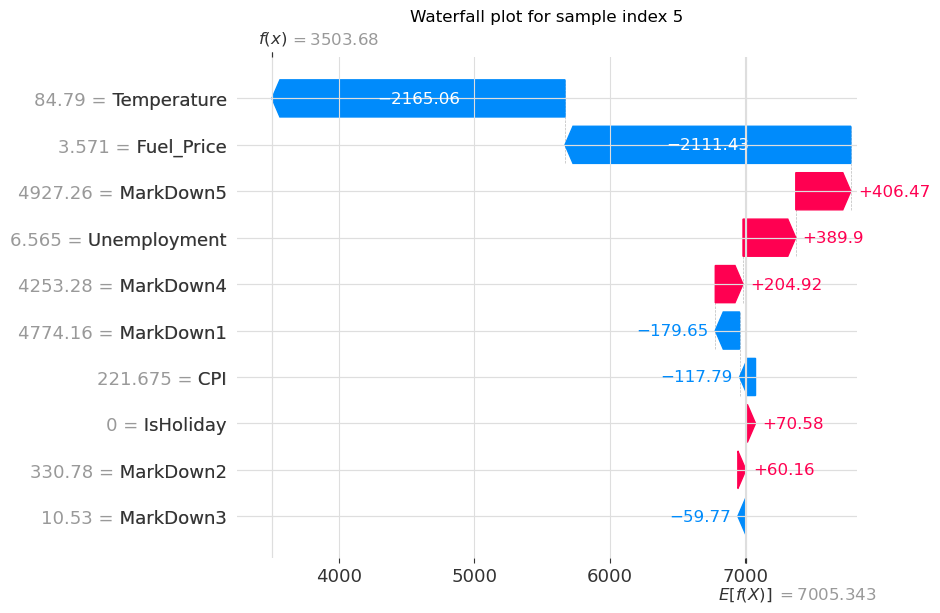

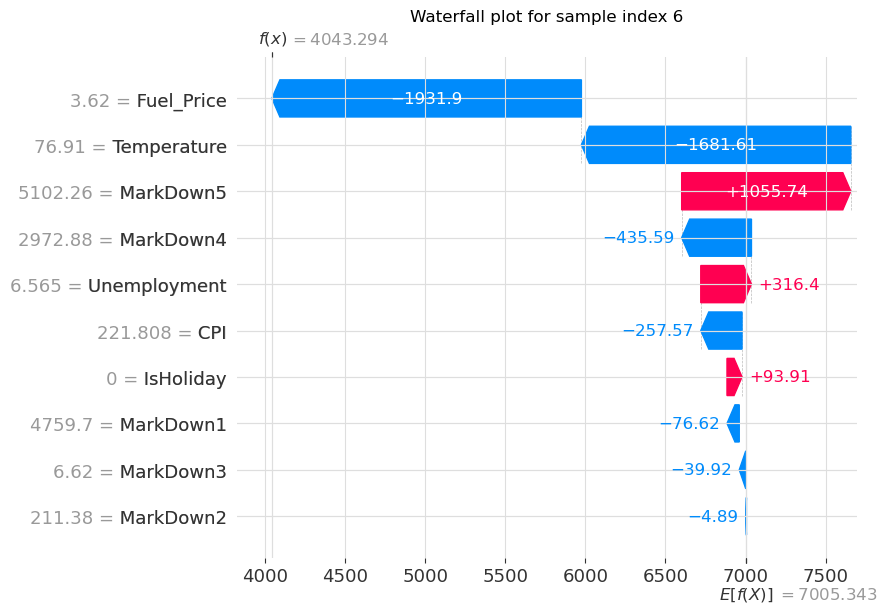

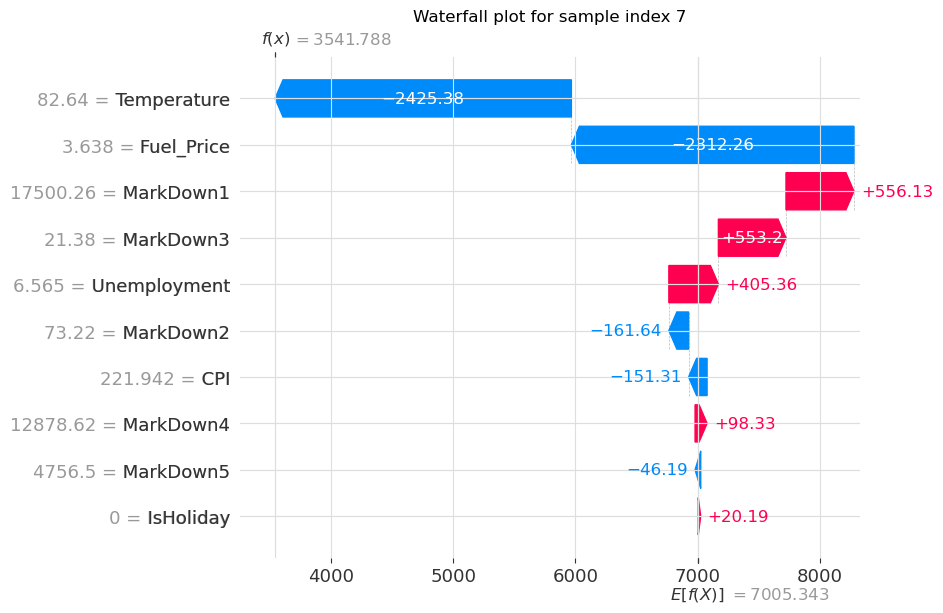

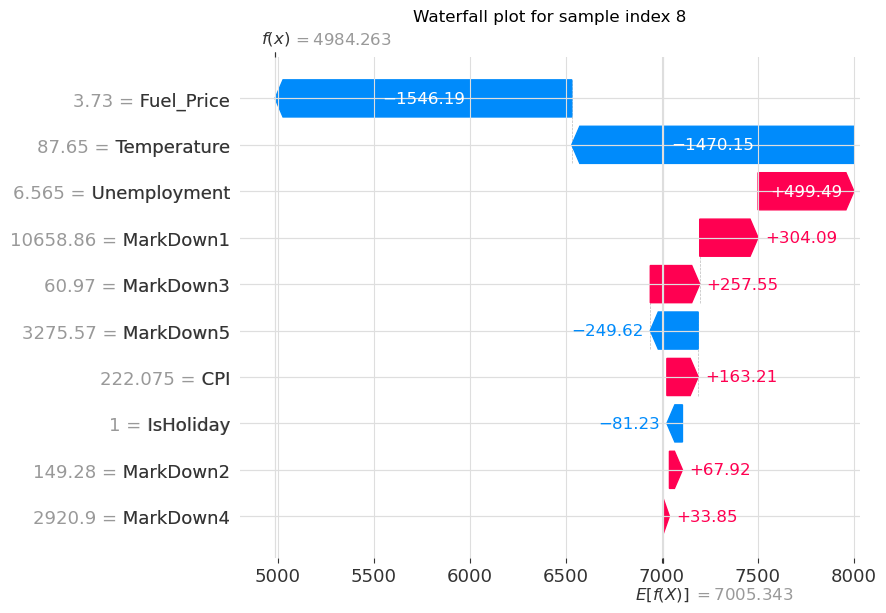

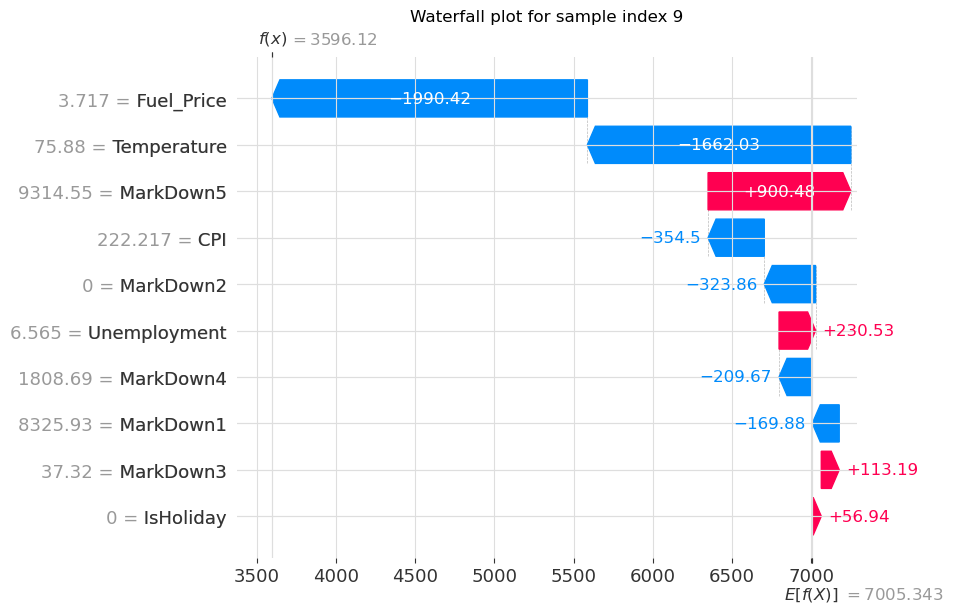

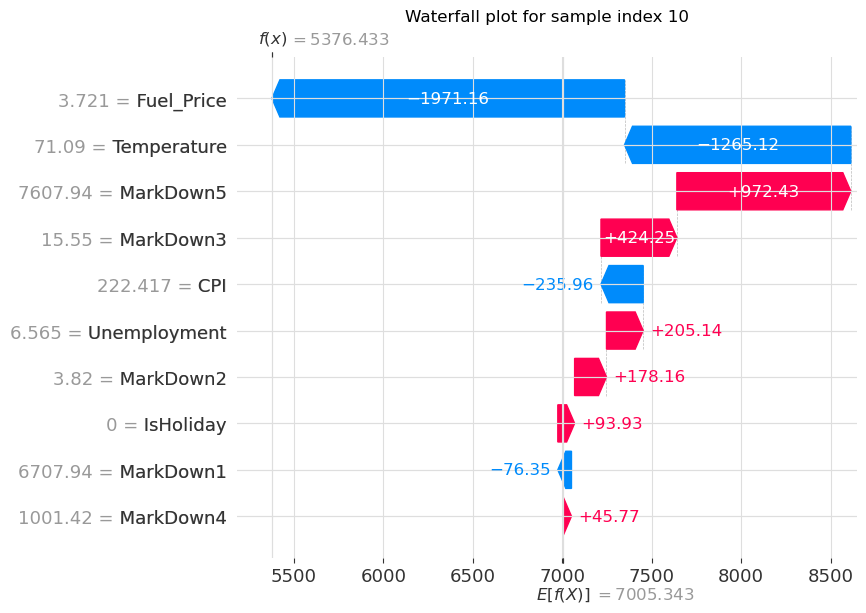

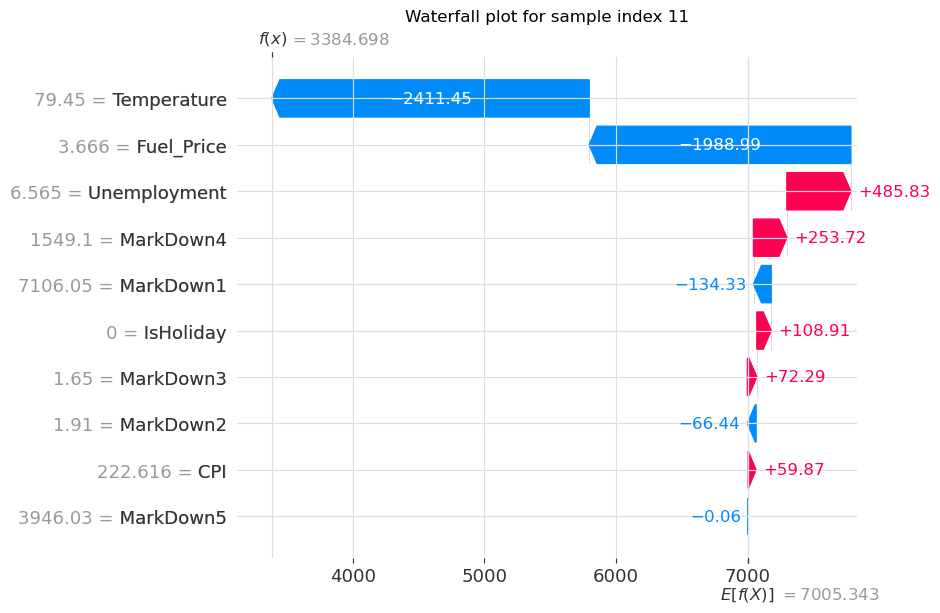

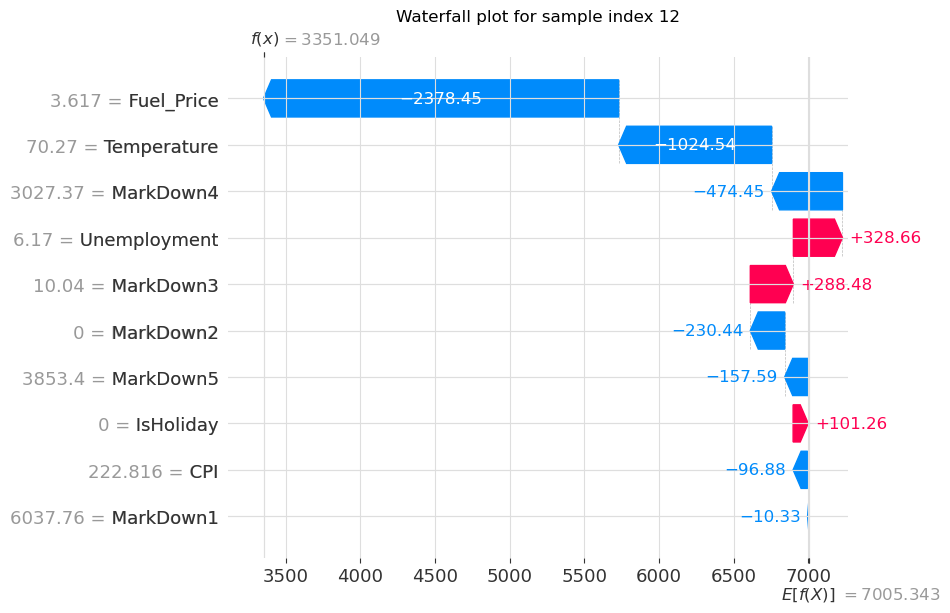

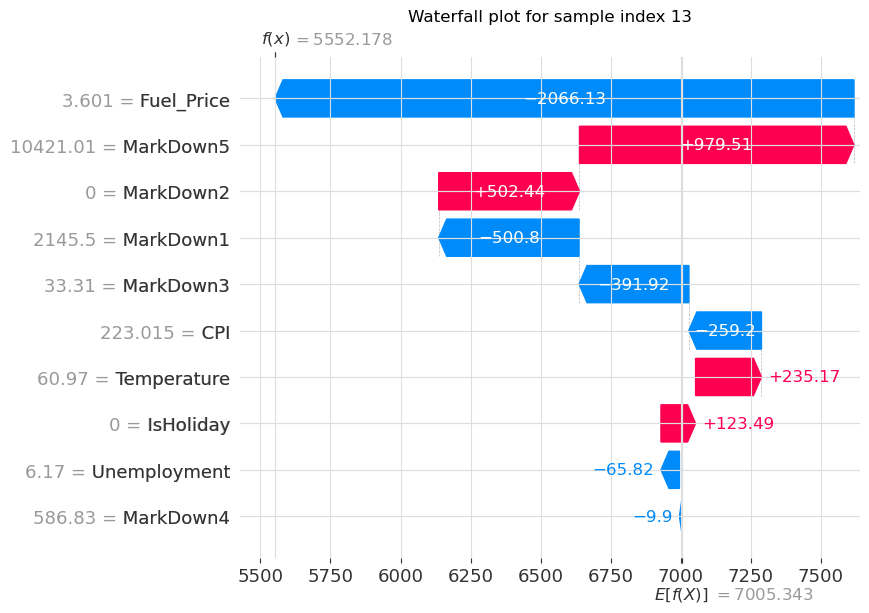

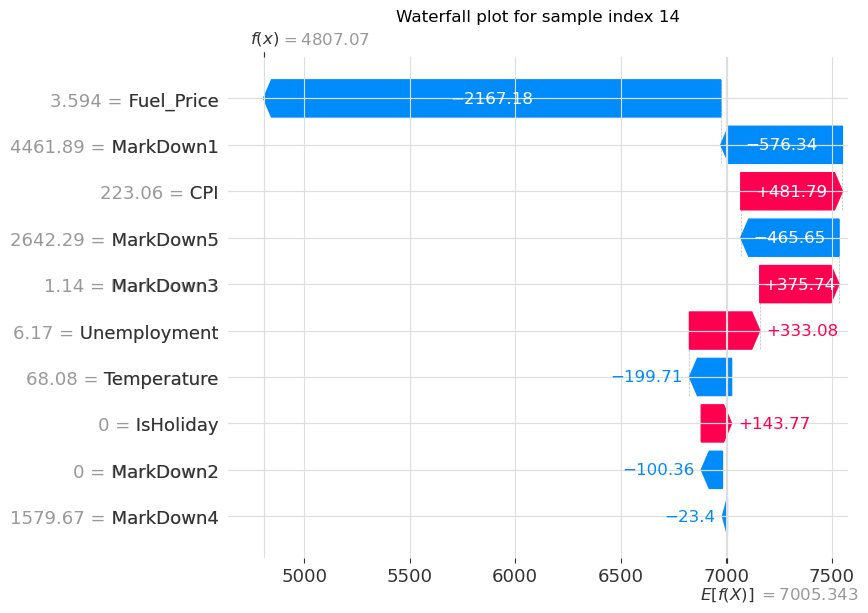

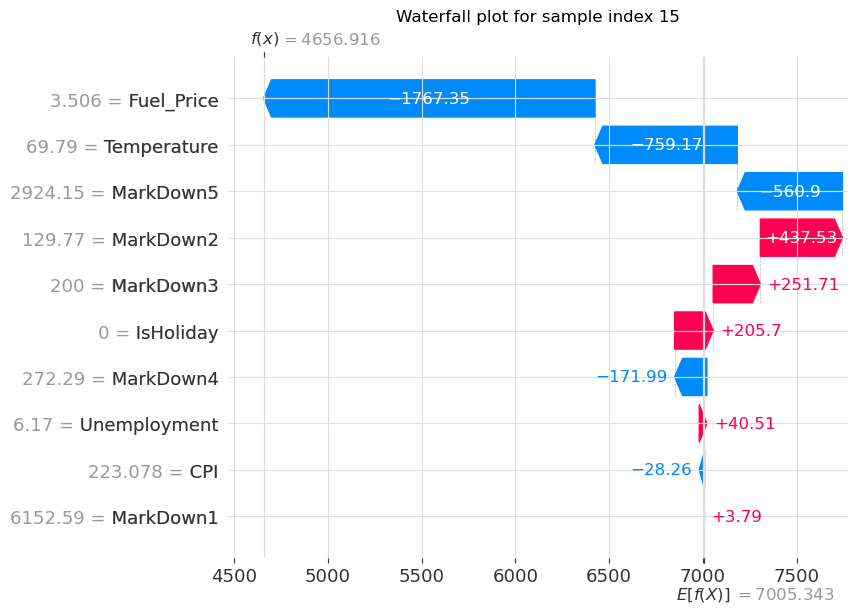

In [44]:
expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0] 

explanation = shap.Explanation(
    values=shap_values,
    base_values=expected_value,  # Valor(es) de base do modelo
    data=X_test.values,          # Dados de entrada
    feature_names=X_test.columns # Nomes das características
)

import matplotlib.pyplot as plt

for sample_ind in range(16): 
    plt.figure() 
    shap.plots.waterfall(explanation[sample_ind], show=False)
    plt.title(f"Waterfall plot for sample index {sample_ind}")
    plt.show()


In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', "IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']], y_train)

print("Melhores parâmetros:", grid_search.best_params_)

best_tree_model = grid_search.best_estimator_

y_pred_tree = best_tree_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_tree, squared=False)
print("RMSE on residuals test set:", rmse)




Fitting 3 folds for each of 45 candidates, totalling 135 fits
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
RMSE on residuals test set: 24516.242988051225


In [46]:
forecast_final_tree= forecast+y_pred_tree
print("RMSE on final forecast test set:", mean_squared_error(test['Weekly_Sales'], forecast_final_tree, squared=False))

RMSE on final forecast test set: 24516.242988051225


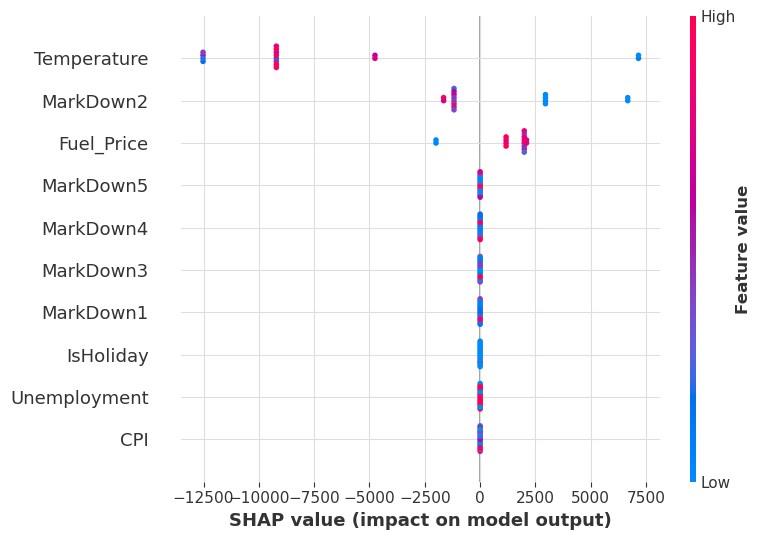

In [47]:
import pandas as pd
from catboost import CatBoostRegressor
import shap


explainer = shap.TreeExplainer(best_tree_model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


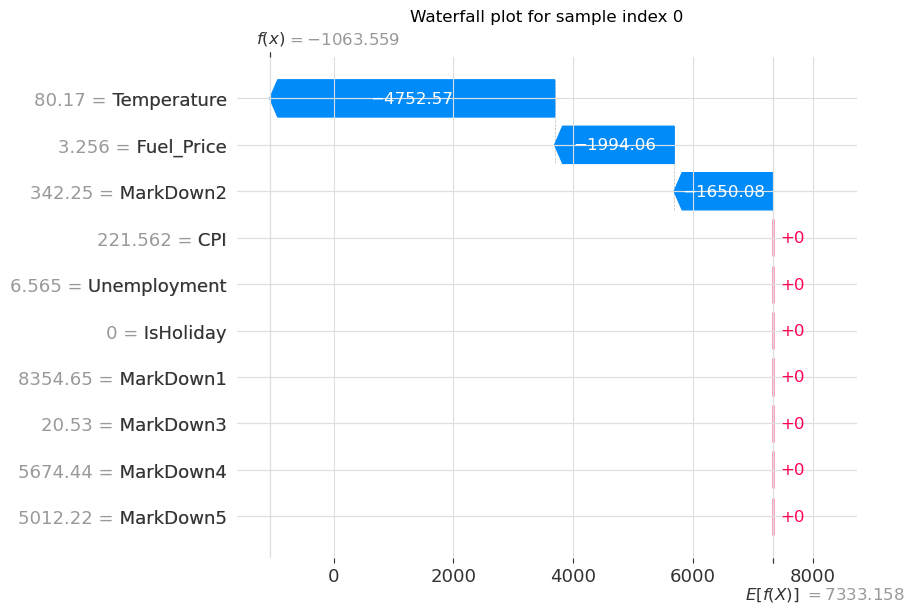

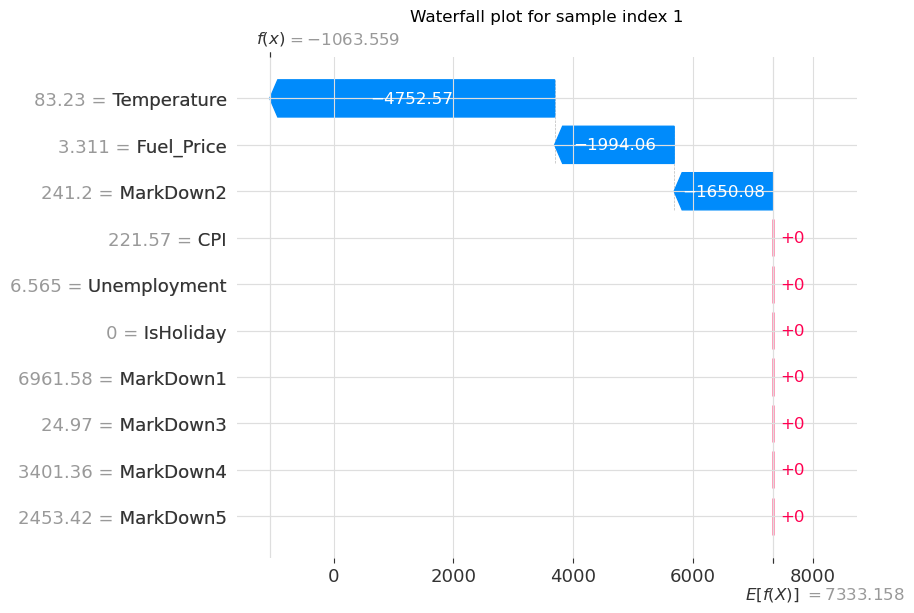

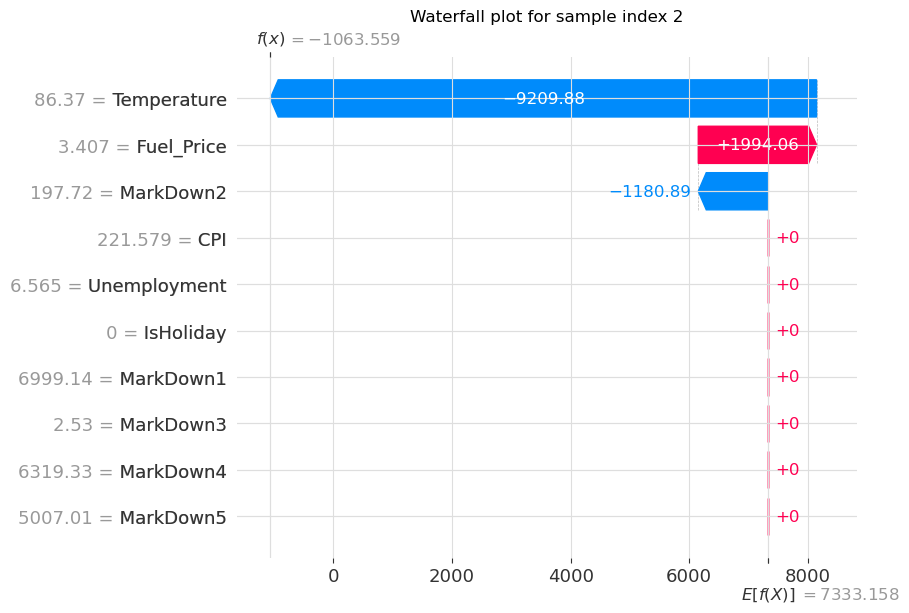

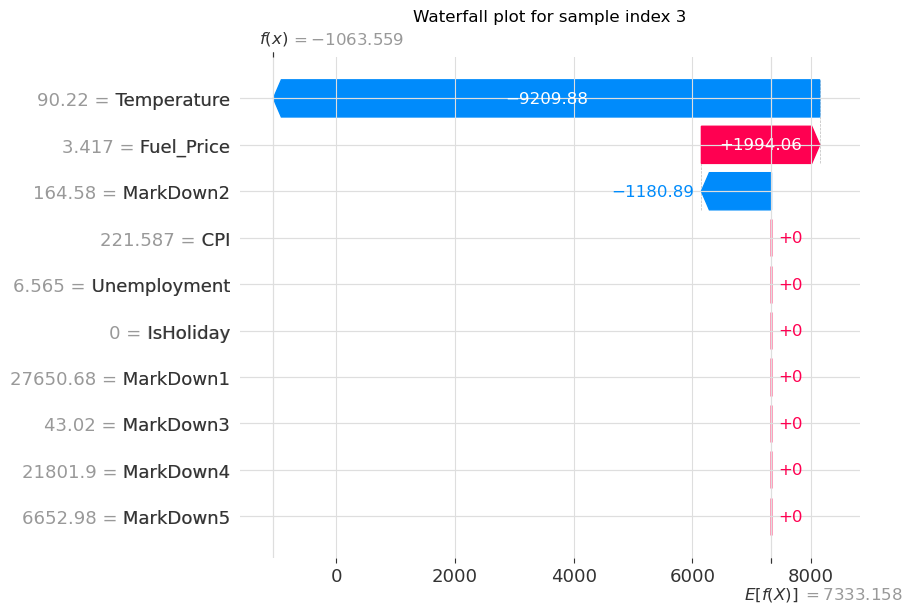

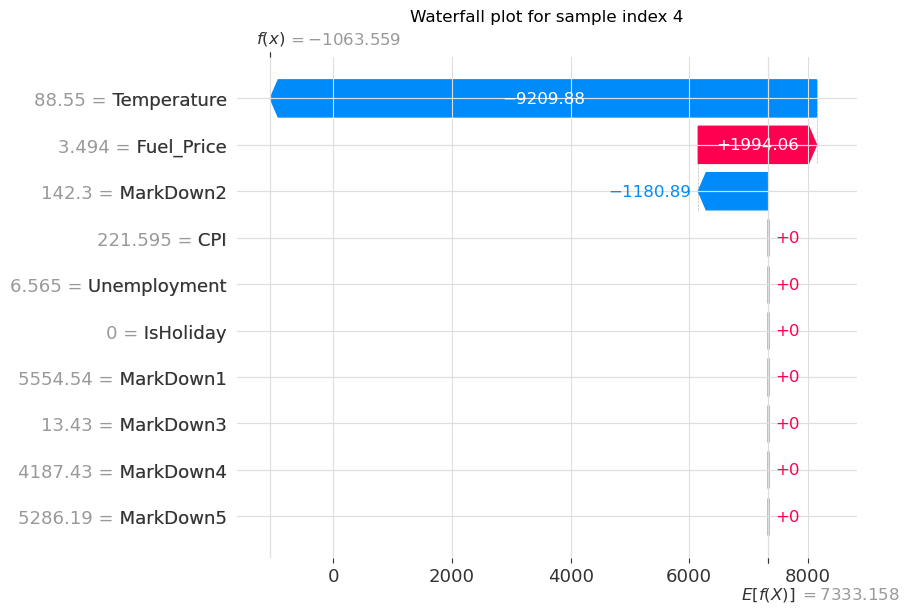

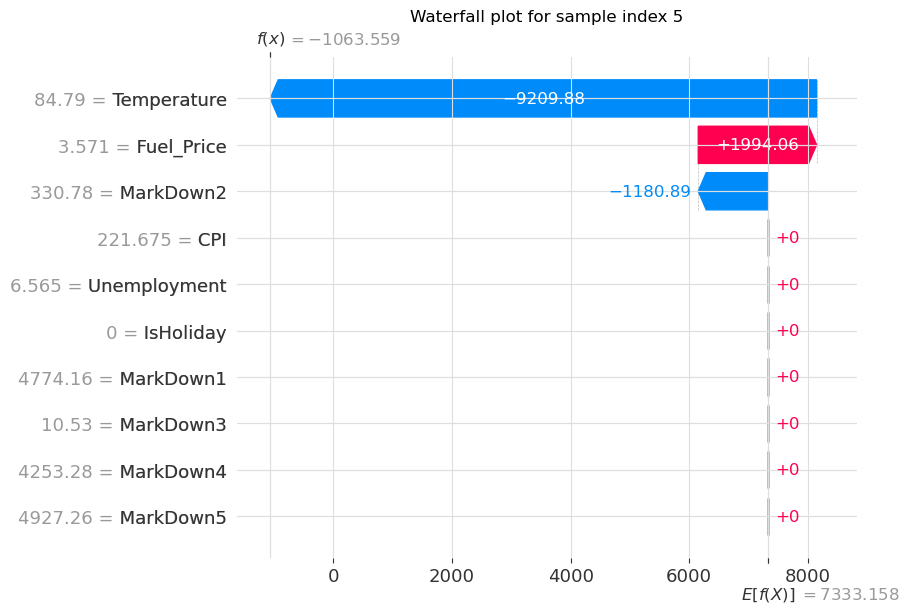

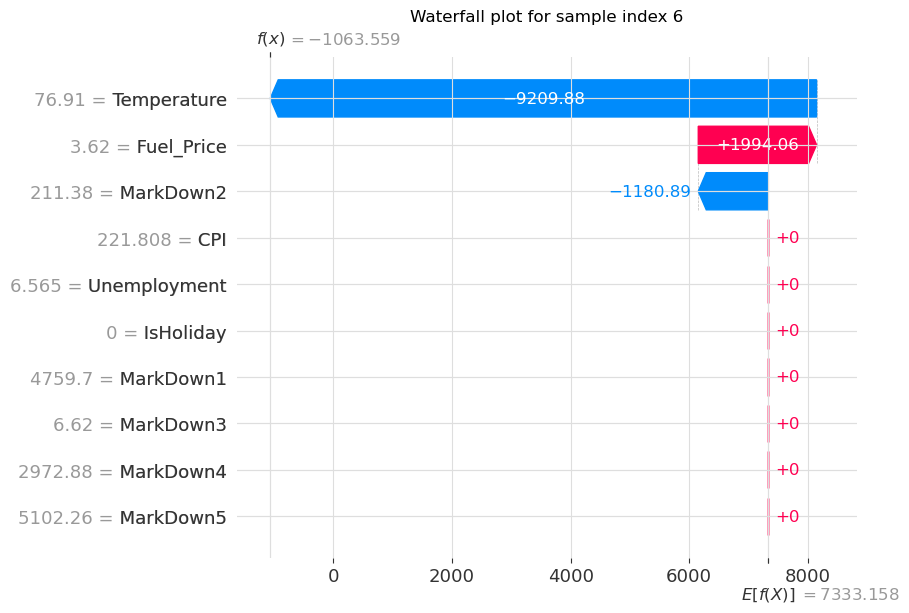

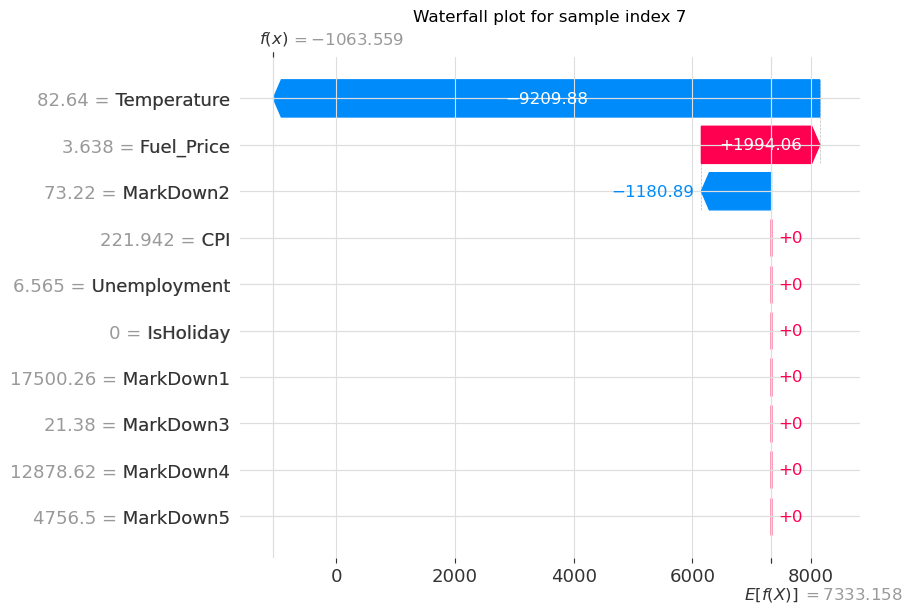

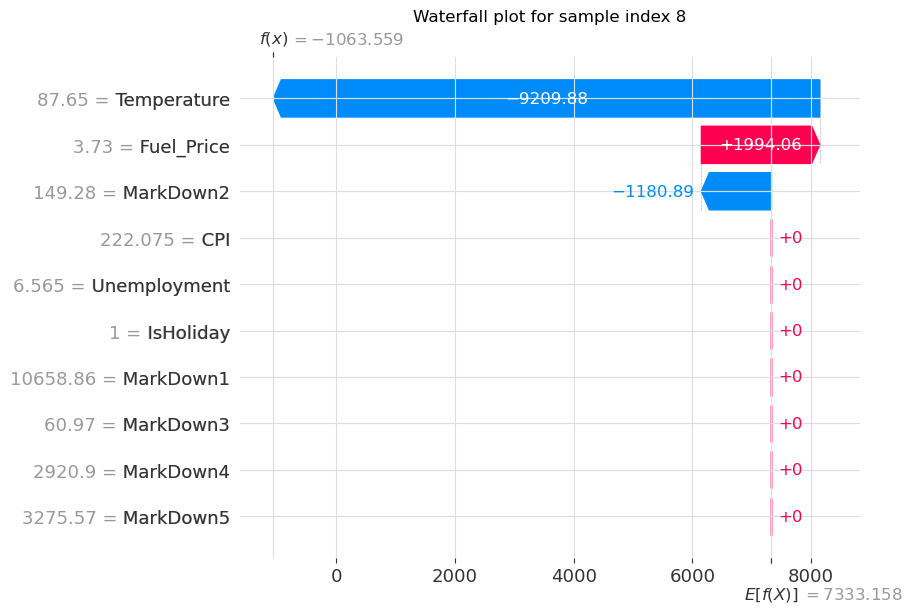

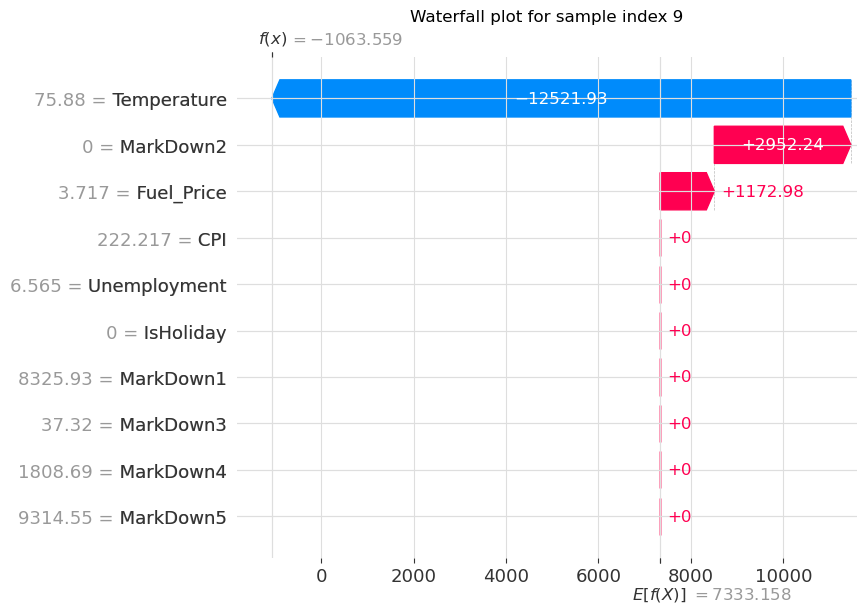

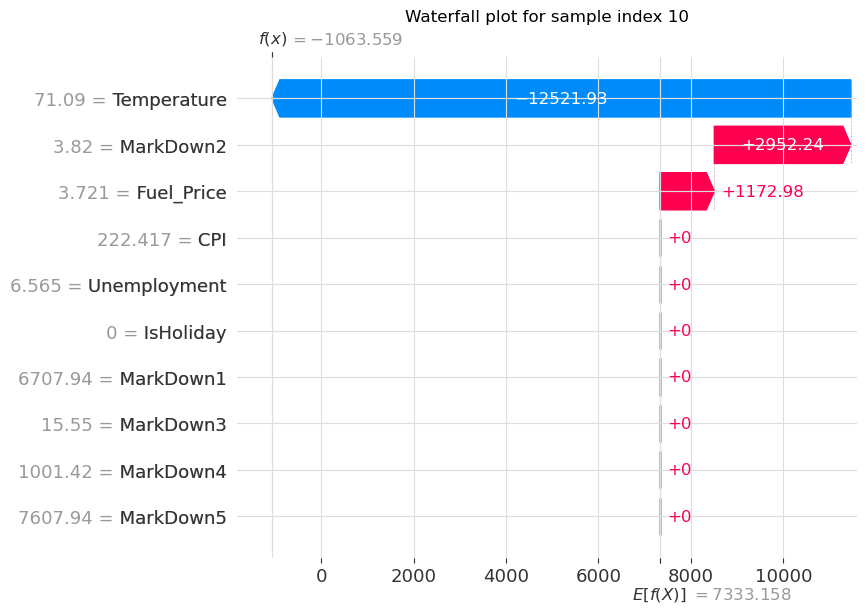

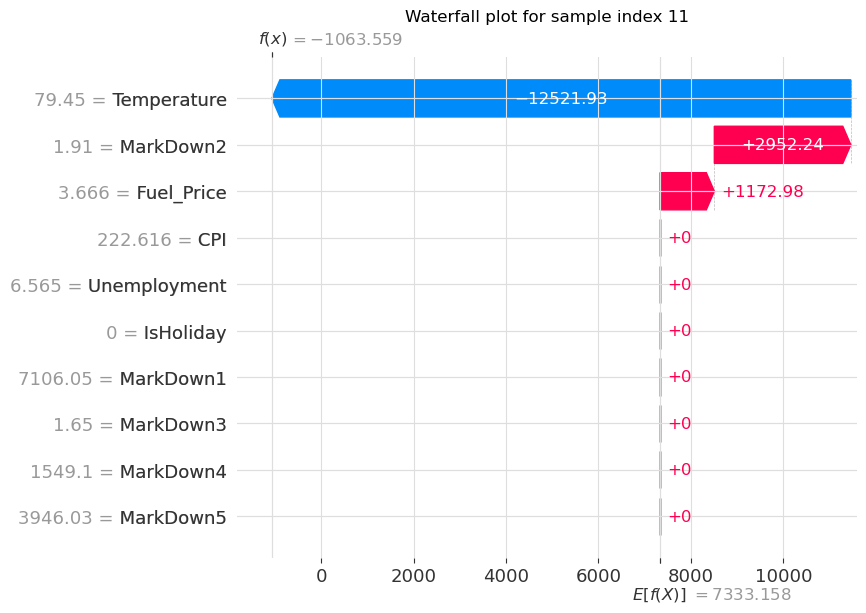

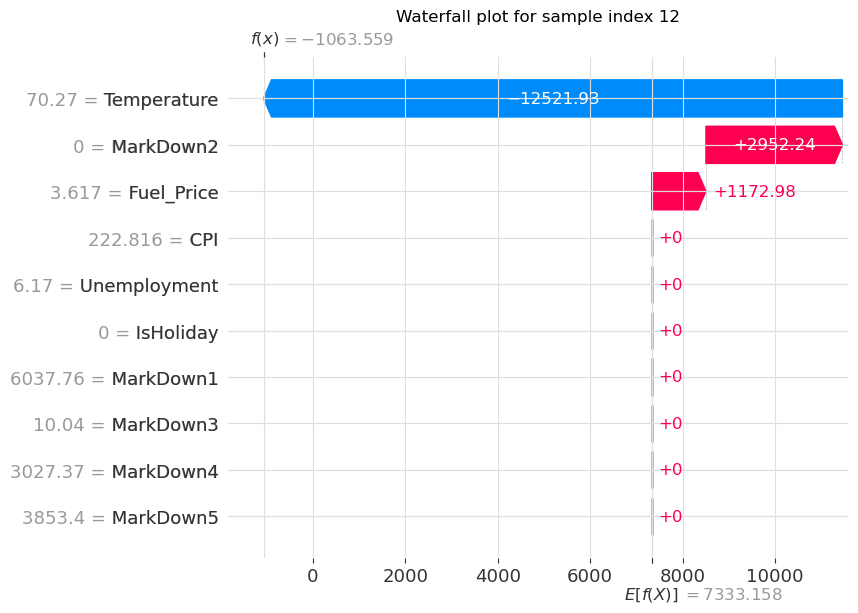

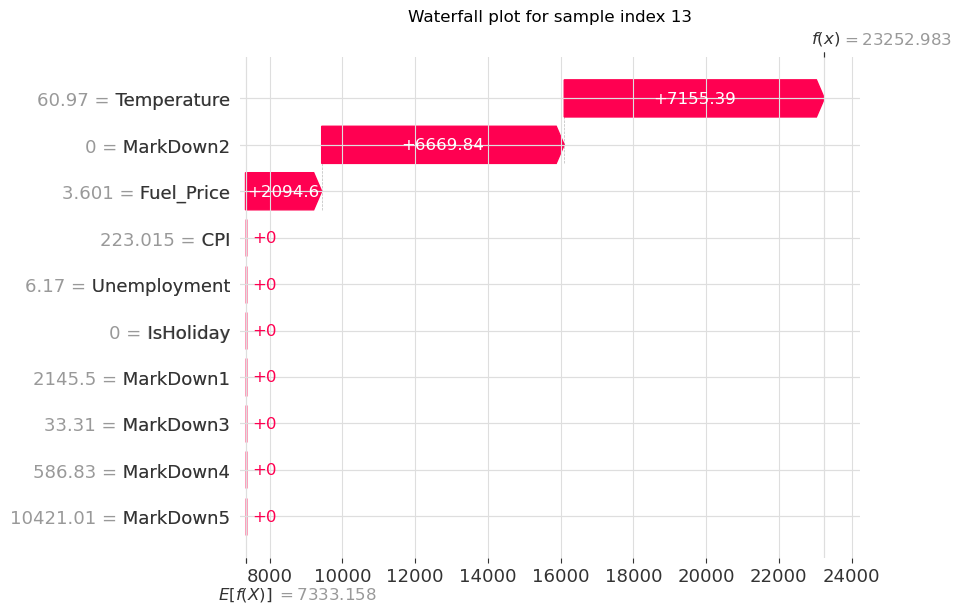

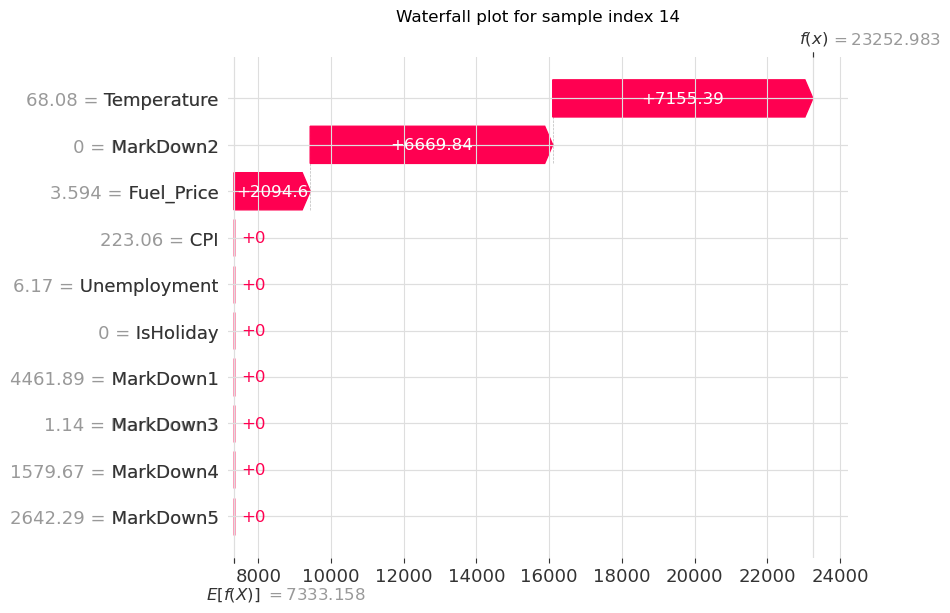

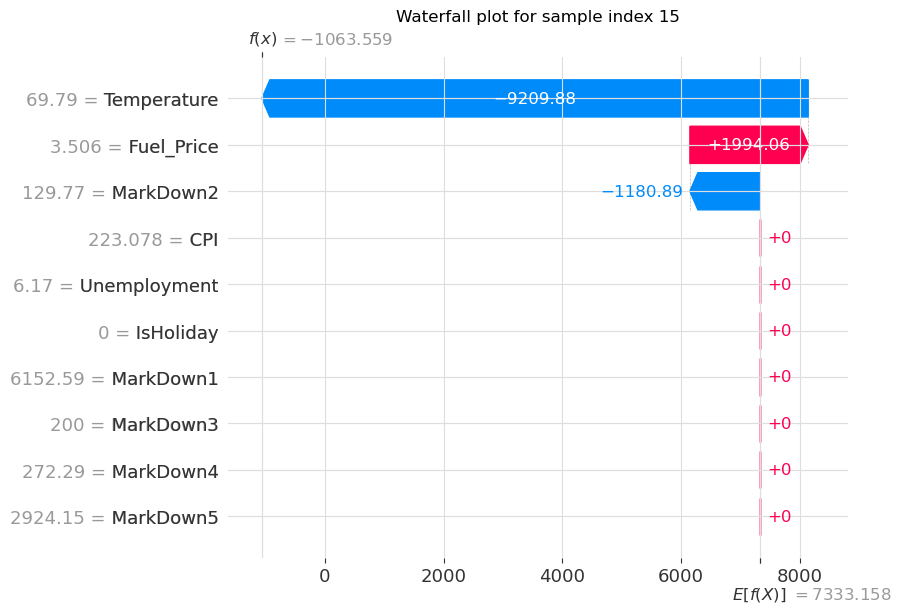

In [48]:
expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0] 

explanation = shap.Explanation(
    values=shap_values,
    base_values=expected_value,  # Valor(es) de base do modelo
    data=X_test.values,          # Dados de entrada
    feature_names=X_test.columns # Nomes das características
)

import matplotlib.pyplot as plt


for sample_ind in range(16):
    plt.figure() 
    shap.plots.waterfall(explanation[sample_ind], show=False)
    plt.title(f"Waterfall plot for sample index {sample_ind}")
    plt.show()


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

pipeline.fit(X_train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']], y_train)

y_pred_lr = pipeline.predict(X_test[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']])

rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
print("RMSE on residuals test set:", rmse)

RMSE on residuals test set: 22959.549364254053


In [50]:
forecast_final_lr= forecast+y_pred_lr
print("RMSE on final forecast test set:", mean_squared_error(test['Weekly_Sales'], forecast_final_lr, squared=False))

RMSE on final forecast test set: 22959.549364254053


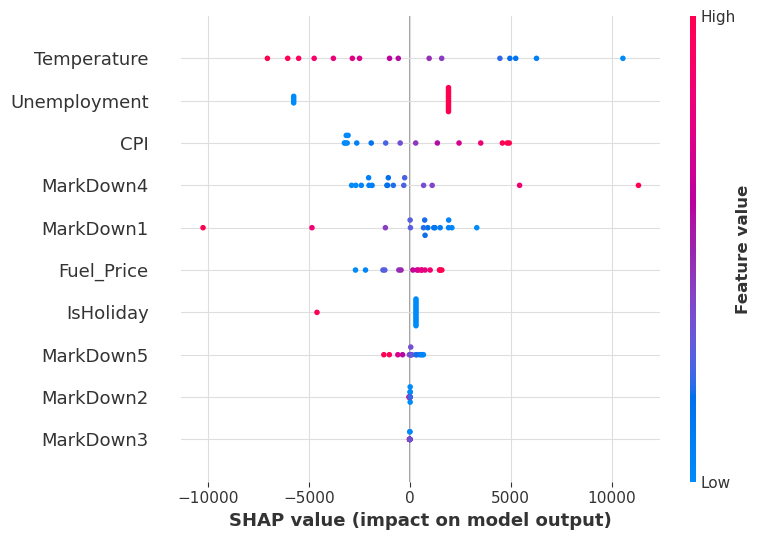

In [51]:
import shap

model = pipeline.named_steps['linear_regression']

scaler = pipeline.named_steps['scaler']

X_test_scaled = scaler.transform(X_test)

explainer = shap.LinearExplainer(model, X_test_scaled)

shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])


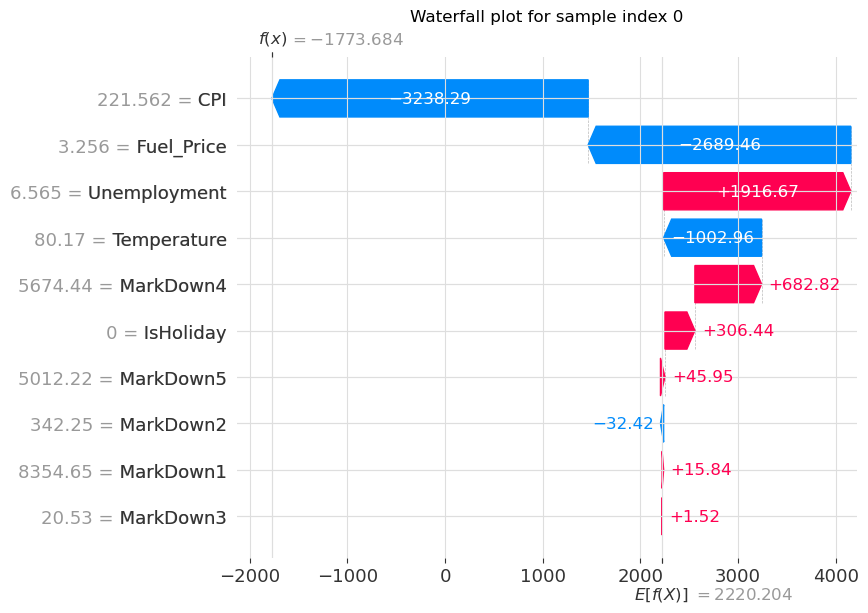

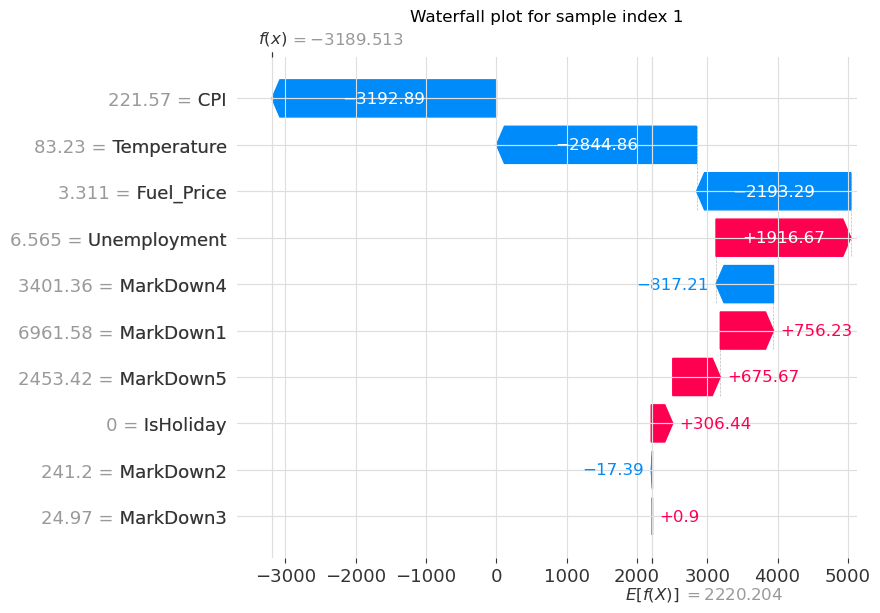

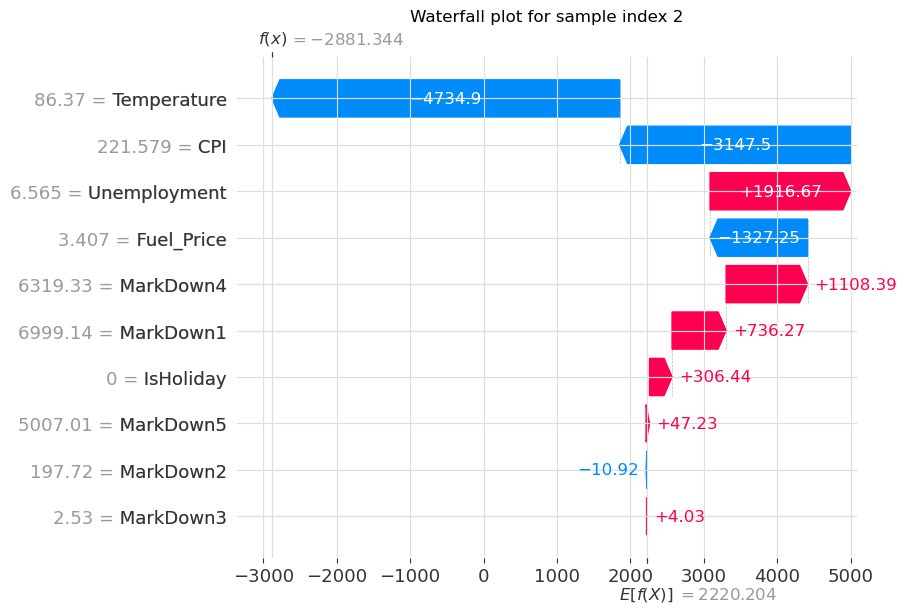

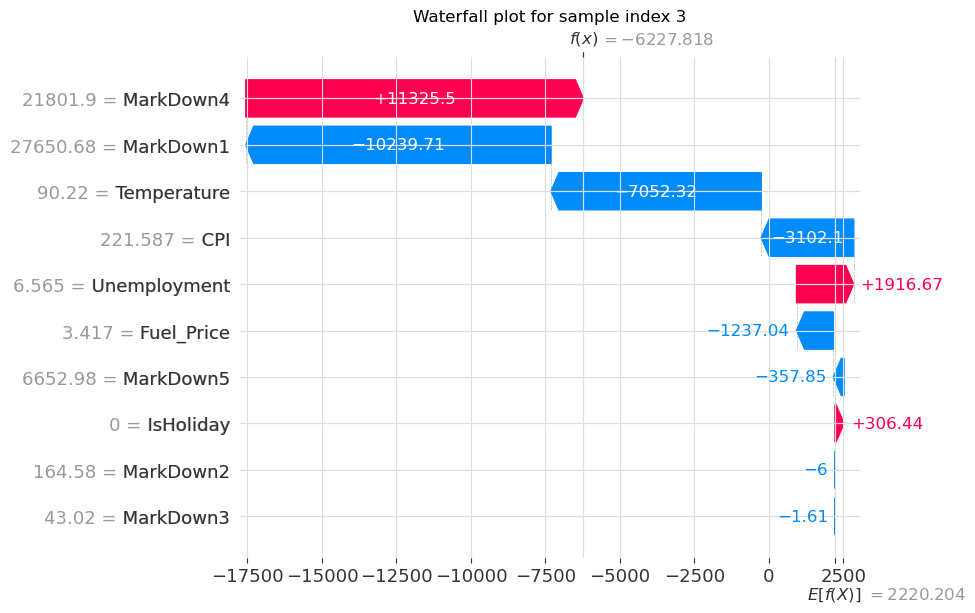

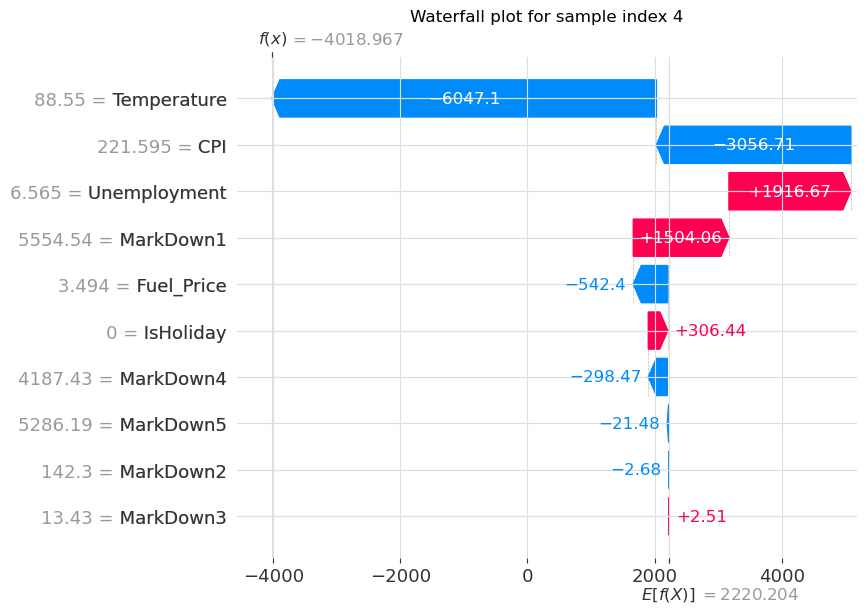

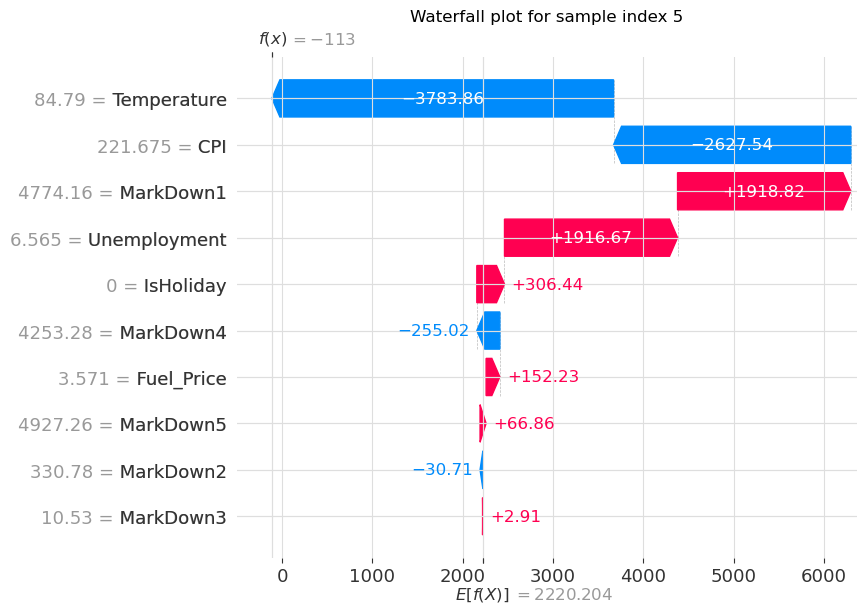

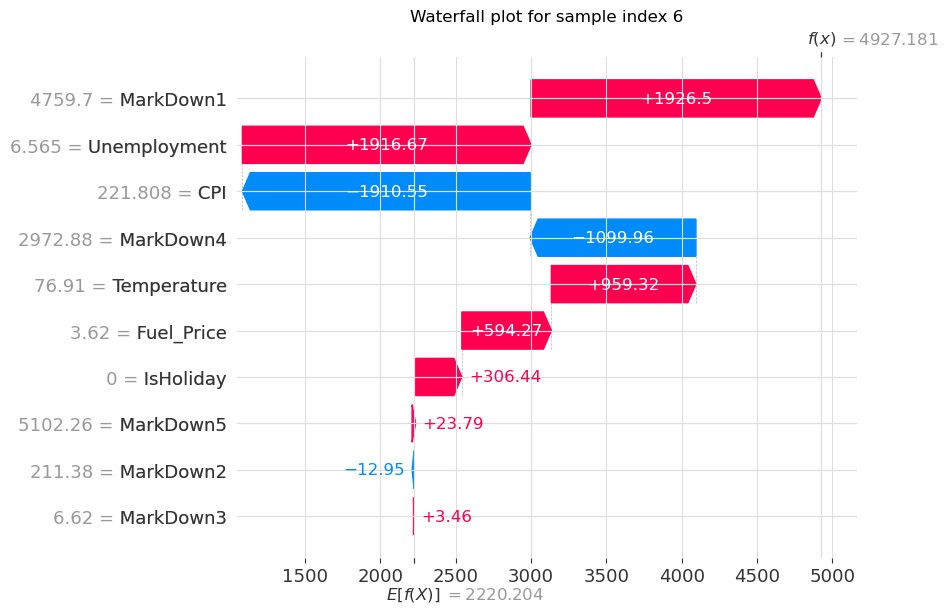

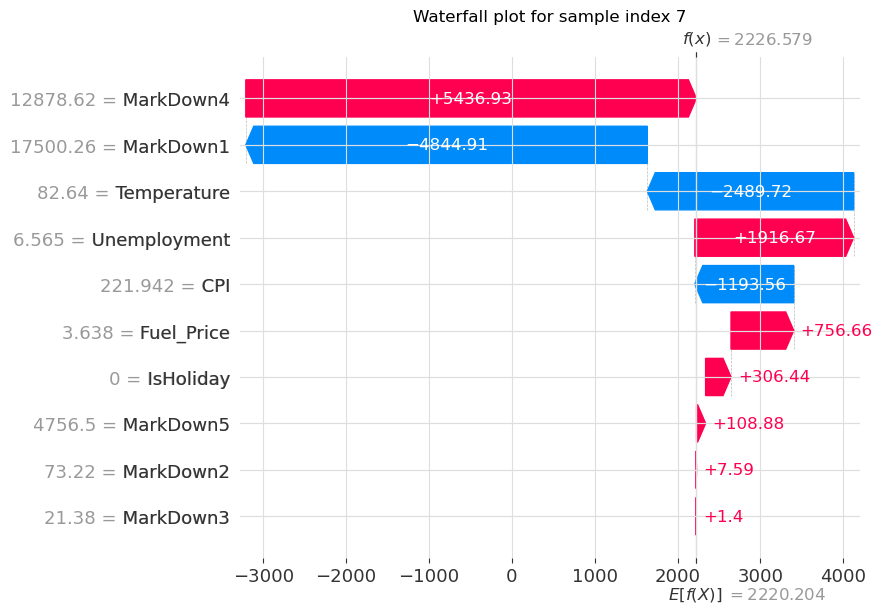

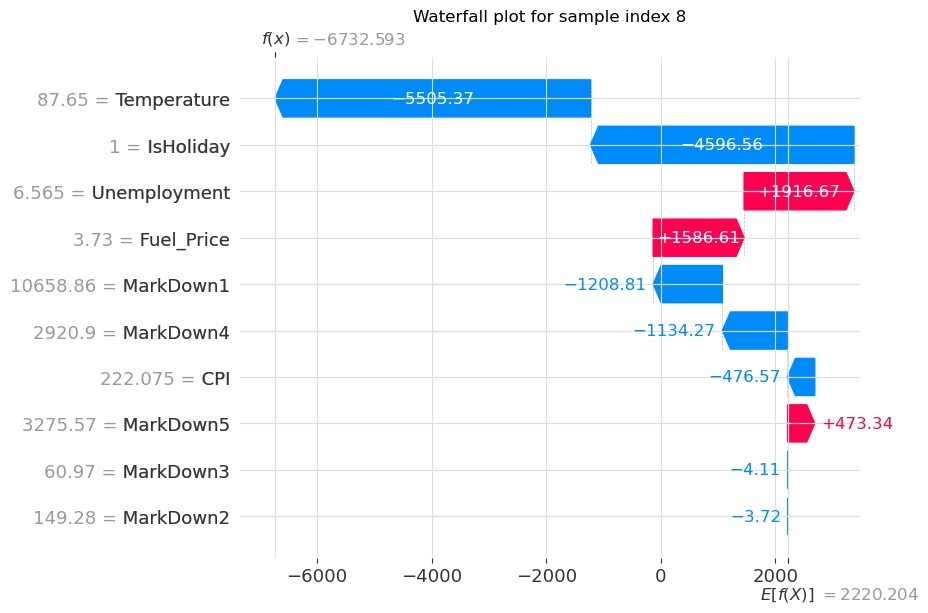

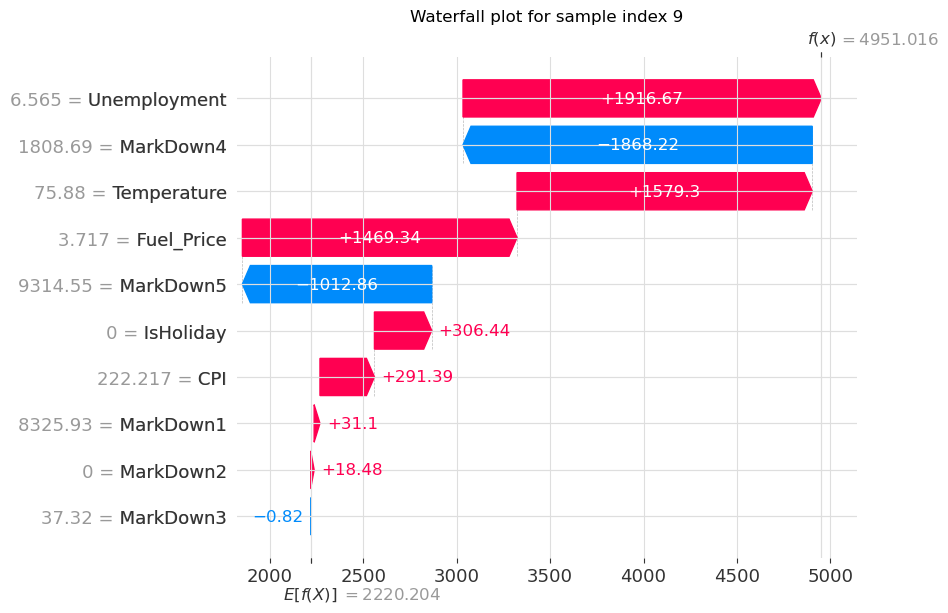

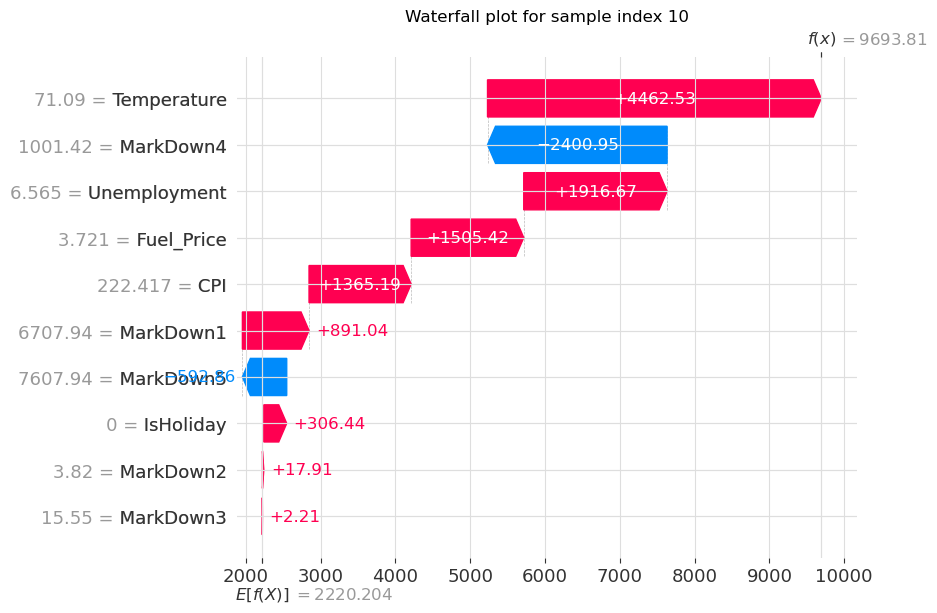

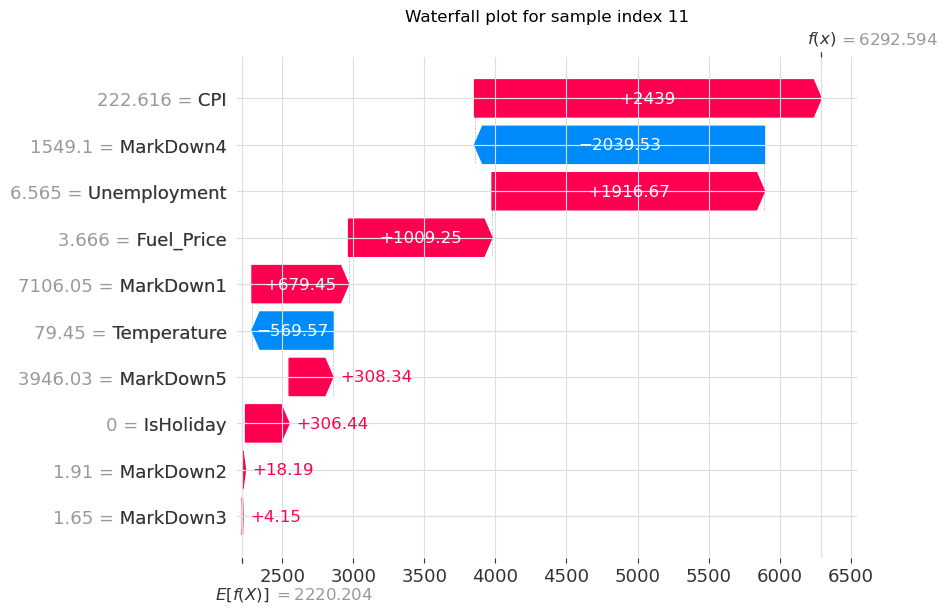

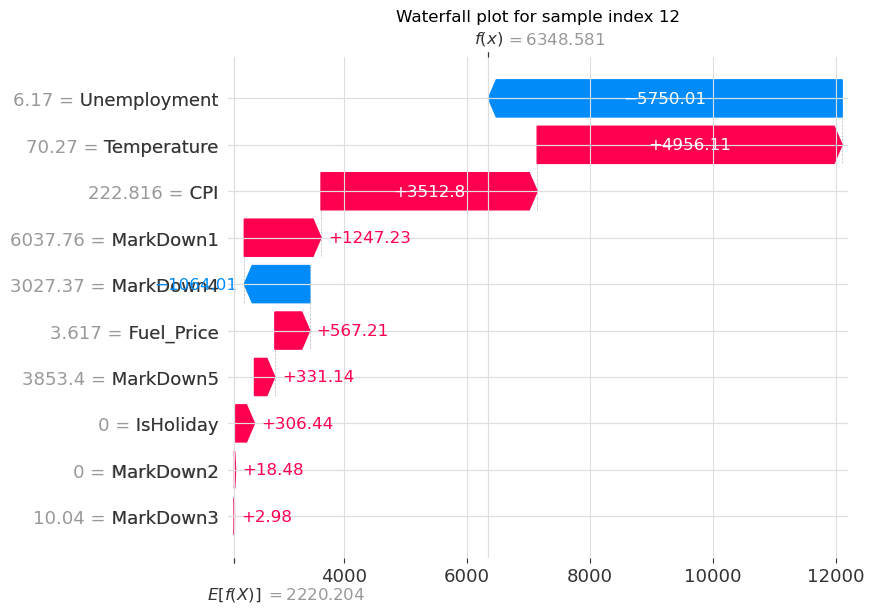

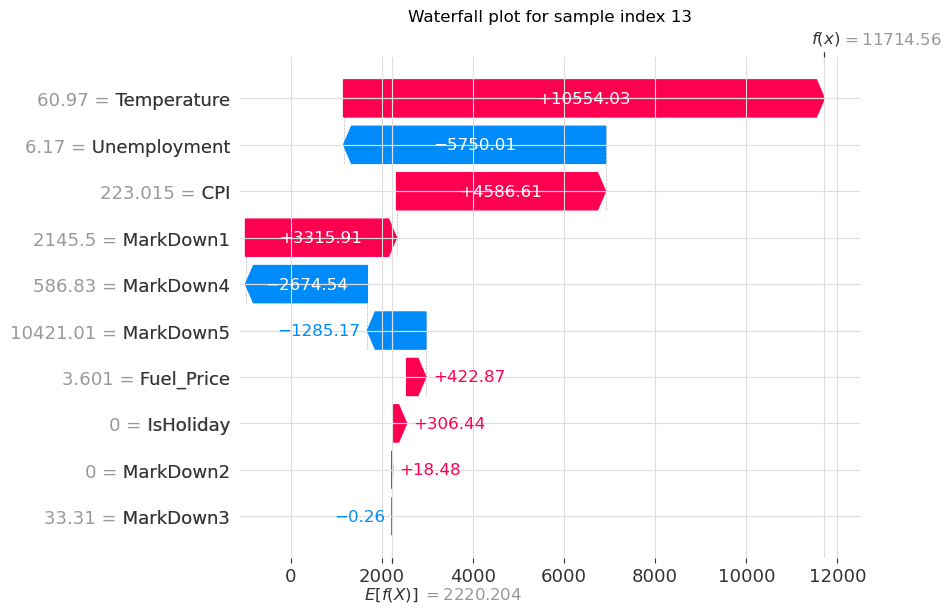

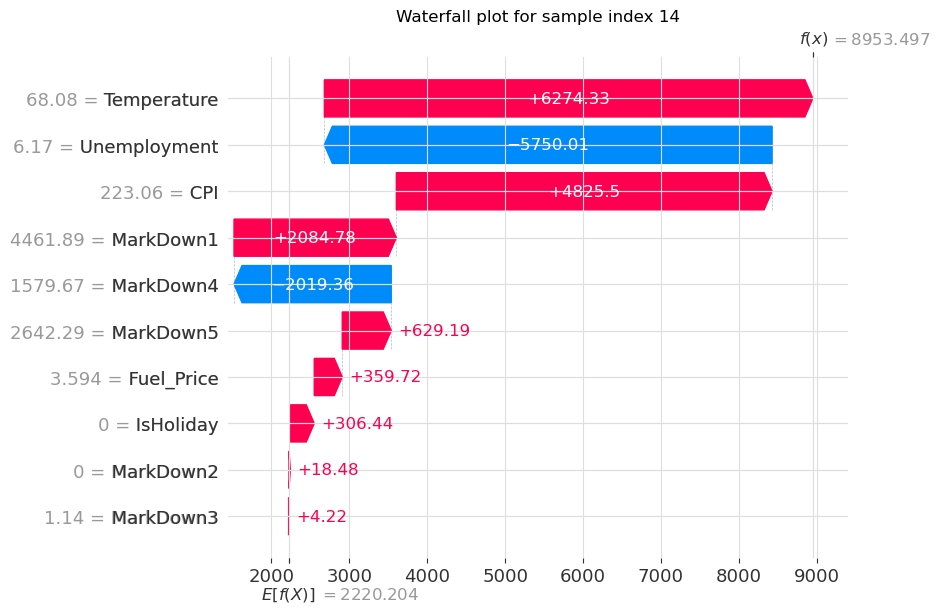

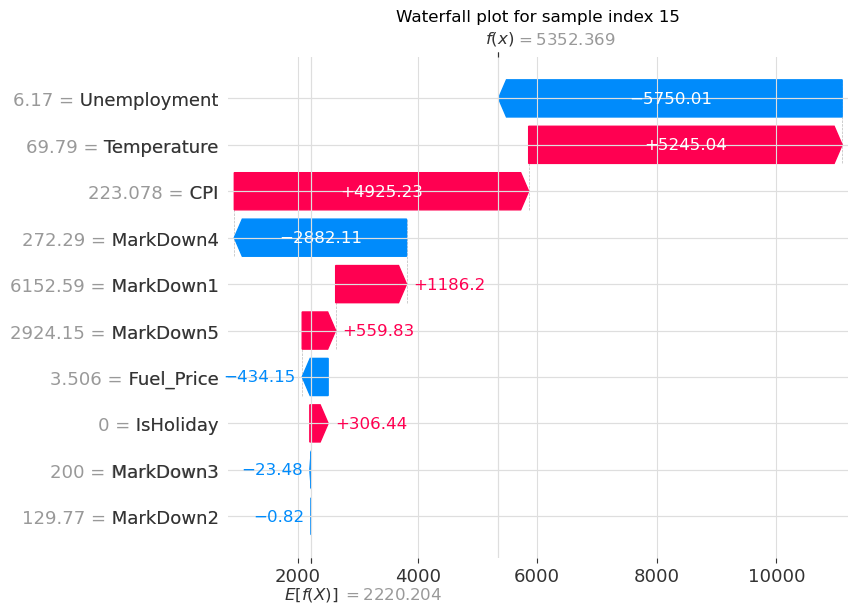

In [52]:
expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0] 

explanation = shap.Explanation(
    values=shap_values,
    base_values=expected_value,  # Valor(es) de base do modelo
    data=X_test.values,          # Dados de entrada
    feature_names=X_test.columns # Nomes das características
)

import matplotlib.pyplot as plt

for sample_ind in range(16):
    plt.figure() 
    shap.plots.waterfall(explanation[sample_ind], show=False)
    plt.title(f"Waterfall plot for sample index {sample_ind}")
    plt.show()
